---
title: "Causal Inference of Labor Market Inequality Using PGM: A multidimensional analysis of unemployment rate"
author:
    name: Mengjia Wei
    email: mw1296@georgetown.edu
    affiliation: Georgetown University
keywords:
  - PGM
  - Unemployment Rate
  - Race
  - Industry
  - Causal Inference
abstract: |
   This study investigates the causal relationships between race, industry, recent graduate, education attainment and unemployment rates in the United States by applying probabilistic graphical modeling (PGM) to uncover latent dependency structures across demographic and industry variables. Using a PGM framework, we construct conditional dependence networks to examine two primary dimensions: racial disparities and industry-specific unemployment dynamics. The analysis first explores the effect of race on unemployment disparities, followed by a sectoral analysis focused on Educational and Health Services, Financial Activities, Public Administration, Information, Leisure and Hospitality, Manufacturing, Professional and Business Services, Transportation and Utilities, and Wholesale and Retail Trade. This study aims to identify whether certain groups—such as Black workers and those employed in Leisure and Hospitality—face heightened unemployment risk, providing a more comprehensive view of labor market hardship. The model estimates the strength and direction of probabilistic dependencies using Bayesian structure learning algorithms, based on BLS Current Population Survey (CPS) data from 2015 to 2025. Findings reveal significant causal effects between race and industry on unemployment. In particular, Black workers in the Leisure and Hospitality sector face notably higher unemployment vulnerability compared to their White and Asian counterparts. Moreover, Leisure and Hospitality exhibits the strongest positive causal effect on unemployment likelihood. This study also explores the causal inference of the recent graduates on unemployment rate under the interactive effect with their education attainment (Bachelor's or Master's) in order to understand whether recent graduates have higher unemployment rate than non-recent graduates in 2025, and the difference between persons who have Bachelor's degree vs. those with Master's degree. These results contribute to the growing literature leveraging PGMs for social inference (e.g., Li et al., 2022), and demonstrate the model’s utility in uncovering structural labor market inequalities across population subgroups.

date: last-modified
bibliography: references.bib
citation:
  container-title: Georgetown Univeristy DSAN 5650 Journal
number-sections: true
jupyter: python3
---

## Introduction

In its revised report released on July 31, 2025, the U.S. Bureau of Labor Statistics (BLS) reported a sharp slowdown in job creation beginning in May, signaling heightened uncertainty and growing concerns about the overall health of the U.S. labor market. The interplay of demographic characteristics and labor market dynamics consistently reveals significant disparities in unemployment rates. Decades of research reveal a persistent relationship between race, gender, and unemployment, evident across diverse economic cycles. Though the Black unemployment rate fell to a historic low of 6.1% in 2019, it was still twice as high as the White unemployment rate of 3.0%, as @ValerieWilson2022 observed. These disparities are further magnified at the intersection of race and gender. For instance, Black men faced a 6.1% unemployment rate in February 2024, notably higher than Black women at 4.4%. Similarly, Hispanic women's unemployment rate increased to 5.0% in February 2024, while Hispanic men experienced a decrease to 4.0% (@Joseph2024). Industry-specific analyses similarly highlight divergent unemployment trends. The Leisure and Hospitality sector reported the highest unemployment rate at 6.0% in 2024, an increase from 5.5% in 2023. Similarly, Wholesale and Retail Trade experienced elevated unemployment, reaching 4.7% in October 2024, up from 4.0% in 2023. Conversely, Financial Activities maintained a significantly lower unemployment rate of 1.9% (@Oberlo2024). 

Research from the U.S. Bureau of Labor Statistics consistently shows longer unemployment spells in sectors such as Manufacturing and Construction, while industries demanding specialized skills like Education and Health Services exhibit shorter durations. Study by @YiLiChienandPaulMorris reveals negative correlation between the unemployment rate and duration. Such variations in both the rate and duration of unemployment underscore complex interactions among race, gender, age, and industry.

@TOIEducation2025 published that the labor market for recent college graduates has "deteriorated noticeably" in the first quarter of 2025. The unemployment rate for this cohort (ages 22-27) ranged from 5.5% to 7.1%, exceeding the overall national average of 4.1-4.2%, with Anthropology (9.4%), Physics (7.8%), and Computer Engineering (7.5%) showing among the highest rates. 

![Unemployment Rate of Recent College Graduates](images/unemployment_rate_recent_graduate.png){#fig-graduates}

Based on revised job reports for May through Jul 2025 released by the U.S. Bureau of Labor Statistics (BLS) on July 31, 2025, the new job creation numbers show a significant decline since May, raising substantial concerns regarding the stability of the U.S. labor market. Recent data clearly indicate a noticeable uptick in the unemployment rate for the 22-27 age group since March, reaching 2021 levels and particularly affecting recent college graduates (@fig-graduates). 

In this study, we are analyzing how race, gender, industry, age and the interactions of these features impact the disparities in the unemployment rate using BLS published historical labor force statistics and survey data.

## Data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#| label: tbl-monthly-unemployment-rate-race
#| tbl-cap: BLS 2015-2025 Monthly Unemployment Rate By Race

# Data pre-processing - part1: Merge monthly unemployment rates by different demographics excel files downlaoded from BLS website
import pandas as pd
import os
#os.getcwd()

def create_df_race(folder_path, demographic_type, id_vars, var_name, value_name):
    merged_df = pd.DataFrame()
    file_name = [f.removesuffix('.xlsx') for f in os.listdir(os.path.join("../data", folder_path)) if f.endswith('.xlsx')]
    for f in file_name:
        file_path = os.path.join("../data", folder_path, f + ".xlsx")    
        df = pd.read_excel(file_path)
        rows = df[df.iloc[:,0]=='Year'].index[0]+2-1
        df = pd.read_excel(file_path, skiprows=rows)
        df_long = df.melt(id_vars=id_vars, var_name=var_name, value_name=value_name)
        df_long[demographic_type] = f
        merged_df = pd.concat([merged_df, df_long], ignore_index=True)
    return merged_df

folder_path_list = ["unemployment_rate_by_race",
             "unemployment_rate_by_sex",
             "unemployment_rate_by_industry",
             "unemployment_rate_by_age",
            "unemployment_rate_by_education_attainment"]

demographic_type_list = ['Race',
                    'Sex',
                    'Industry',
                    'Age',
                    'Education_attainment']

d_vars="Year"
var_name="Month"
value_name="Unemployment_rate"

df_dic = {}
for i in range(0, len(folder_path_list)):
    folder_path = folder_path_list[i]
    demographic_type=demographic_type_list[i]
    merged_df = create_df_race(folder_path, demographic_type, "Year", "Month", "Unemployment_rate")
    df_dic[demographic_type] = merged_df

display(df_dic['Race'].head(10).style.hide(axis='index').format({'Unemployment_rate':'{:.2f}'}))

#list(df_dic.values())[0]

Year,Month,Unemployment_rate,Race
2015,Jan,5.30,white
2016,Jan,4.70,white
2017,Jan,4.70,white
2018,Jan,3.90,white
2019,Jan,4.00,white
2020,Jan,3.50,white
2021,Jan,6.20,white
2022,Jan,3.90,white
2023,Jan,3.50,white
2024,Jan,3.80,white


Data from the U.S. Bureau of Labor Statistics (BLS) 2015 to 2025 monthly aggregated unemployment rate by races. This dataset is used to analyze the unemployment rate variations by race, which help define prior parameters for the predictions.  (@tbl-monthly-unemployment-rate-race).

In [3]:
# Data pre-processing - part2: Load and process monthly unemployment overall file
df_overall = pd.read_excel("../data/unemployment_rate_monthly_data.xlsx", skiprows=11)
df_overall_long = df_overall.melt(id_vars="Year", var_name="Month", value_name="Unemployment_rate")

In [4]:
#| label: tbl-survey-data-jun-jul-2025
#| tbl-cap: BLS June 2025 Labor Force Survey Data

# Data pre-processing - part3: Load and process Jun 2025 BLS labor survey data
# process the survey data
import numpy as np
df_survey_jun = pd.read_csv("../data/survey_data/jun_2025.csv")
df_survey_jul = pd.read_csv("../data/survey_data/jul_2025.csv")
df_survey_jun_jul = pd.concat([df_survey_jun, df_survey_jul], ignore_index = True)
df_survey_jun_jul.columns= ["sex","education_attainment","race","age","employment_status",
                        "unmployment_duration","industry","occupation","industry_detailed",
                        "occupation_detailed"]
## create mapping tables to convert the demographic codes to the descriptions

# sex mapping
sex_mapping = {
        1: "male",
        2: "female"
}

# education attainment mapping
education_attainment_codes = list(np.arange(31,47))
education_attainment_values = [
        'less_than_high_school',
		'less_than_high_school',
		'less_than_high_school',
        'less_than_high_school',
'less_than_high_school',
'less_than_high_school',
'less_than_high_school',
'less_than_high_school',
'high_school',
'some_college_or_associate_degree',
'some_college_or_associate_degree',
'some_college_or_associate_degree',
'bachelors_degree',
'masters_degree',
'professional_degree',
'doctoral_degree'
    ]    
education_attainment_mapping=dict(zip(education_attainment_codes,education_attainment_values))

# race mapping
race_codes = list(np.arange(1,27))
race_values = [
        "white",
        "black",
        "other",
        "asian"
    ] + ["other"] * 22
race_mapping= dict(zip(race_codes, race_values))

# age mapping
race_codes = list(np.arange(1,27))
race_values = [
        "white",
        "black",
        "other",
        "asian"
    ] + ["other"] * 22
race_mapping= dict(zip(race_codes, race_values))

# employment status mapping
employment_status_codes =[
        1,2,3,4,5,6,7
    ]
employment_status_names = [
        "employed",
        "employed",
        "unemployed",
        "unemployed",
        "not in labor force",
        "not in labor force",
        "not in labor force"
    ]
employment_status_mapping = dict(zip(employment_status_codes,employment_status_names))

# industry name mapping
industry_codes = list(np.arange(1,15))
industry_names = [
    "Agriculture, forestry, fishing, and hunting",
    "Mining",
    "Construction",
    "Manufacturing",
    "Wholesale and retail trade",
    "Transportation and utilities",
    "Information",
    "Financial activities",
    "Professional and business services",
    "Educational and health services",
    "Leisure and hospitality",
    "Other services",
    "Public administration",
    "Armed Forces"
    ]
industry_mapping = dict(zip(industry_codes, industry_names))

## Create new columns with decoded names
df_survey_jun_jul['sex_name'] = df_survey_jun_jul['sex'].map(sex_mapping)
df_survey_jun_jul['race_name'] = df_survey_jun_jul['race'].map(race_mapping)
df_survey_jun_jul['education_attainment_name'] = df_survey_jun_jul['education_attainment'].map(education_attainment_mapping)
df_survey_jun_jul['employment_status_name'] = df_survey_jun_jul['employment_status'].map(employment_status_mapping)
df_survey_jun_jul['industry_name'] = df_survey_jun_jul['industry'].map(industry_mapping)

## Filter out industry_name na rows
df_survey_jun_jul = df_survey_jun_jul[~df_survey_jun_jul['industry_name'].isna()]

## Add columns "is_black" and "unemployment_status" for the binary model
df_survey_jun_jul['is_black_african'] = (df_survey_jun_jul['race_name']=='black').astype(int)

## Add column is_asian for the binary model
df_survey_jun_jul['is_asian'] = (df_survey_jun_jul['race_name']=='asian').astype(int)

## Add column is_asian for the binary model
df_survey_jun_jul['is_white'] = (df_survey_jun_jul['race_name']=='white').astype(int)

## Add column employment_status for the binary model
df_survey_jun_jul['unemployment_status'] = (df_survey_jun_jul['employment_status_name']=='unemployed').astype(int)

## Display the table
display(df_survey_jun_jul.loc[:,[col for col in df_survey_jun_jul.columns if 'name' in col or col == 'is_black_african'  or col == 'is_white'  or col == 'is_asian']].head(10).style.hide(axis='index'))

sex_name,race_name,education_attainment_name,employment_status_name,industry_name,is_black_african,is_asian,is_white
male,white,bachelors_degree,employed,Construction,0,0,1
male,white,high_school,employed,Construction,0,0,1
female,white,bachelors_degree,employed,Manufacturing,0,0,1
male,white,bachelors_degree,employed,Manufacturing,0,0,1
female,white,masters_degree,employed,Transportation and utilities,0,0,1
female,white,bachelors_degree,employed,Construction,0,0,1
male,white,high_school,employed,Wholesale and retail trade,0,0,1
female,white,bachelors_degree,employed,Professional and business services,0,0,1
male,white,less_than_high_school,employed,Professional and business services,0,0,1
female,white,high_school,employed,Educational and health services,0,0,1


We are using June and July 2025 data - the labor force survey result that provides individual-level employment status and corresponding demographic information. For the purpose of this study, a subset of these relevant columns is utilized (@tbl-survey-data-jun-jul-2025). This dataset is used to sample and predict employment status using the observations in the data.

In [5]:
#| label: tbl-survey-data-2024-2025
#| tbl-cap: BLS 2024 - 2025 Jan - Jul Labor Force Survey Data

## Data pre-processing part3: Process monthly survey data of 2024 Jan-Jul and 2025 Jan-Jul
survey_file_names = [f.removesuffix(".csv") for f in os.listdir('../data/survey_data') if f.endswith("csv")]
cols = ['prmjind1', 'pemlr'] # keep columns industry and employment_status
survey_df = []
for s in survey_file_names:
    survey_file = pd.read_csv(os.path.join('../data/survey_data/', s + ".csv" ))
    survey_data = survey_file[cols]
    survey_data.columns=['industry','employment_status']
    survey_data['month_year'] = s
    survey_df.append(survey_data)
# Combine all into a single DataFrame
survey_df = pd.concat(survey_df, ignore_index=True)
# decode the industry and employment_status columns
survey_df['industry_name'] = survey_df['industry'].map(industry_mapping)
survey_df = survey_df[~survey_df['industry_name'].isna()]
survey_df['employment_status_description'] = survey_df['employment_status'].map(employment_status_mapping)
display(survey_df.head(10).style.hide(axis='index'))

industry,employment_status,month_year,industry_name,employment_status_description
11,1,jan_2024,Leisure and hospitality,employed
11,1,jan_2024,Leisure and hospitality,employed
10,1,jan_2024,Educational and health services,employed
5,1,jan_2024,Wholesale and retail trade,employed
4,4,jan_2024,Manufacturing,unemployed
8,1,jan_2024,Financial activities,employed
9,1,jan_2024,Professional and business services,employed
5,1,jan_2024,Wholesale and retail trade,employed
4,1,jan_2024,Manufacturing,employed
4,1,jan_2024,Manufacturing,employed


Data from the U.S. Bureau of Labor Statistics (BLS) historical monthly labor force survey provide individual-level employment status by industries. For the purpose of this study, we utilized 2024 Jan to Jul and 2025 Jan to Jun data. (@tbl-survey-data-2024-2025). This dataset is used to analyze the industry effect on unemployment rate in the recent 2 years.


## EDA
### Unemployment Rates of Differenet Races

Unemployment Rate Distribution Histograms By Race


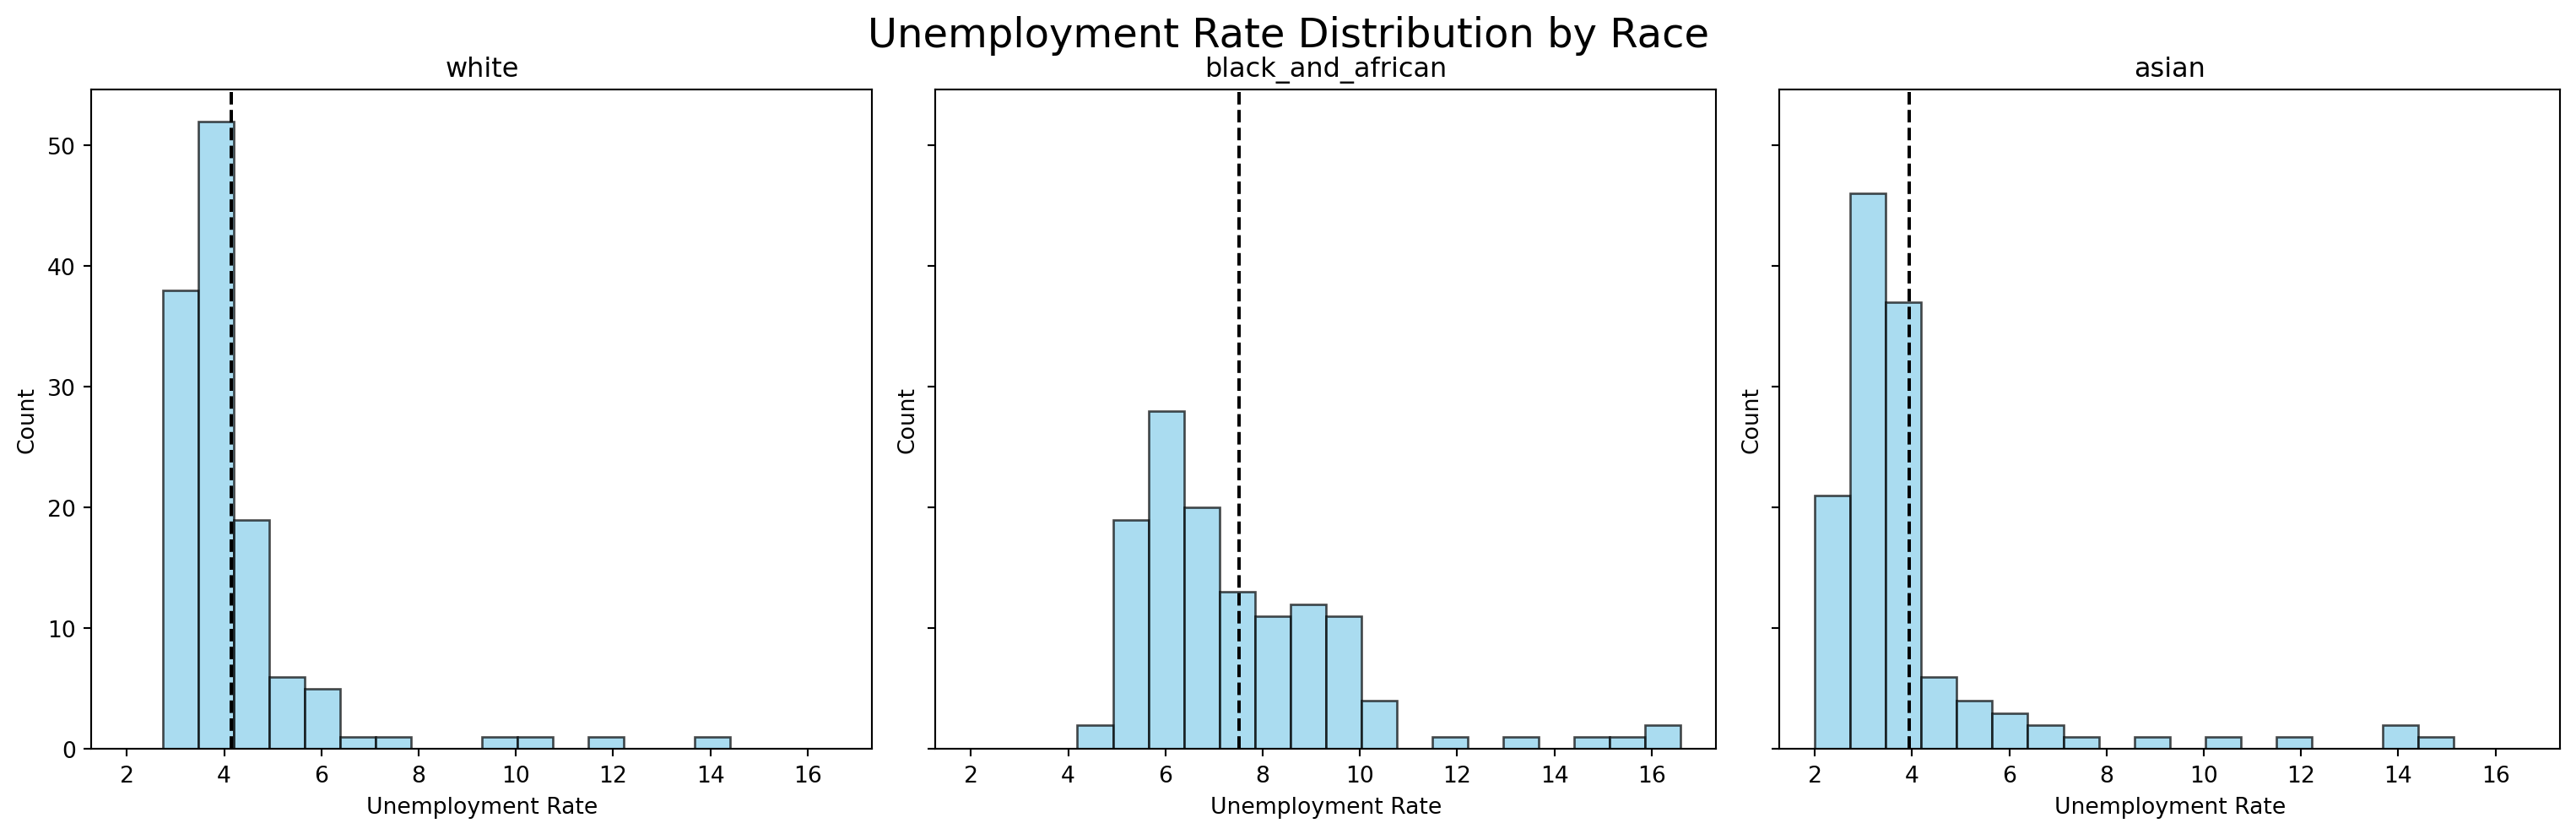

Unemployment Rate Distribution Histograms By Sex


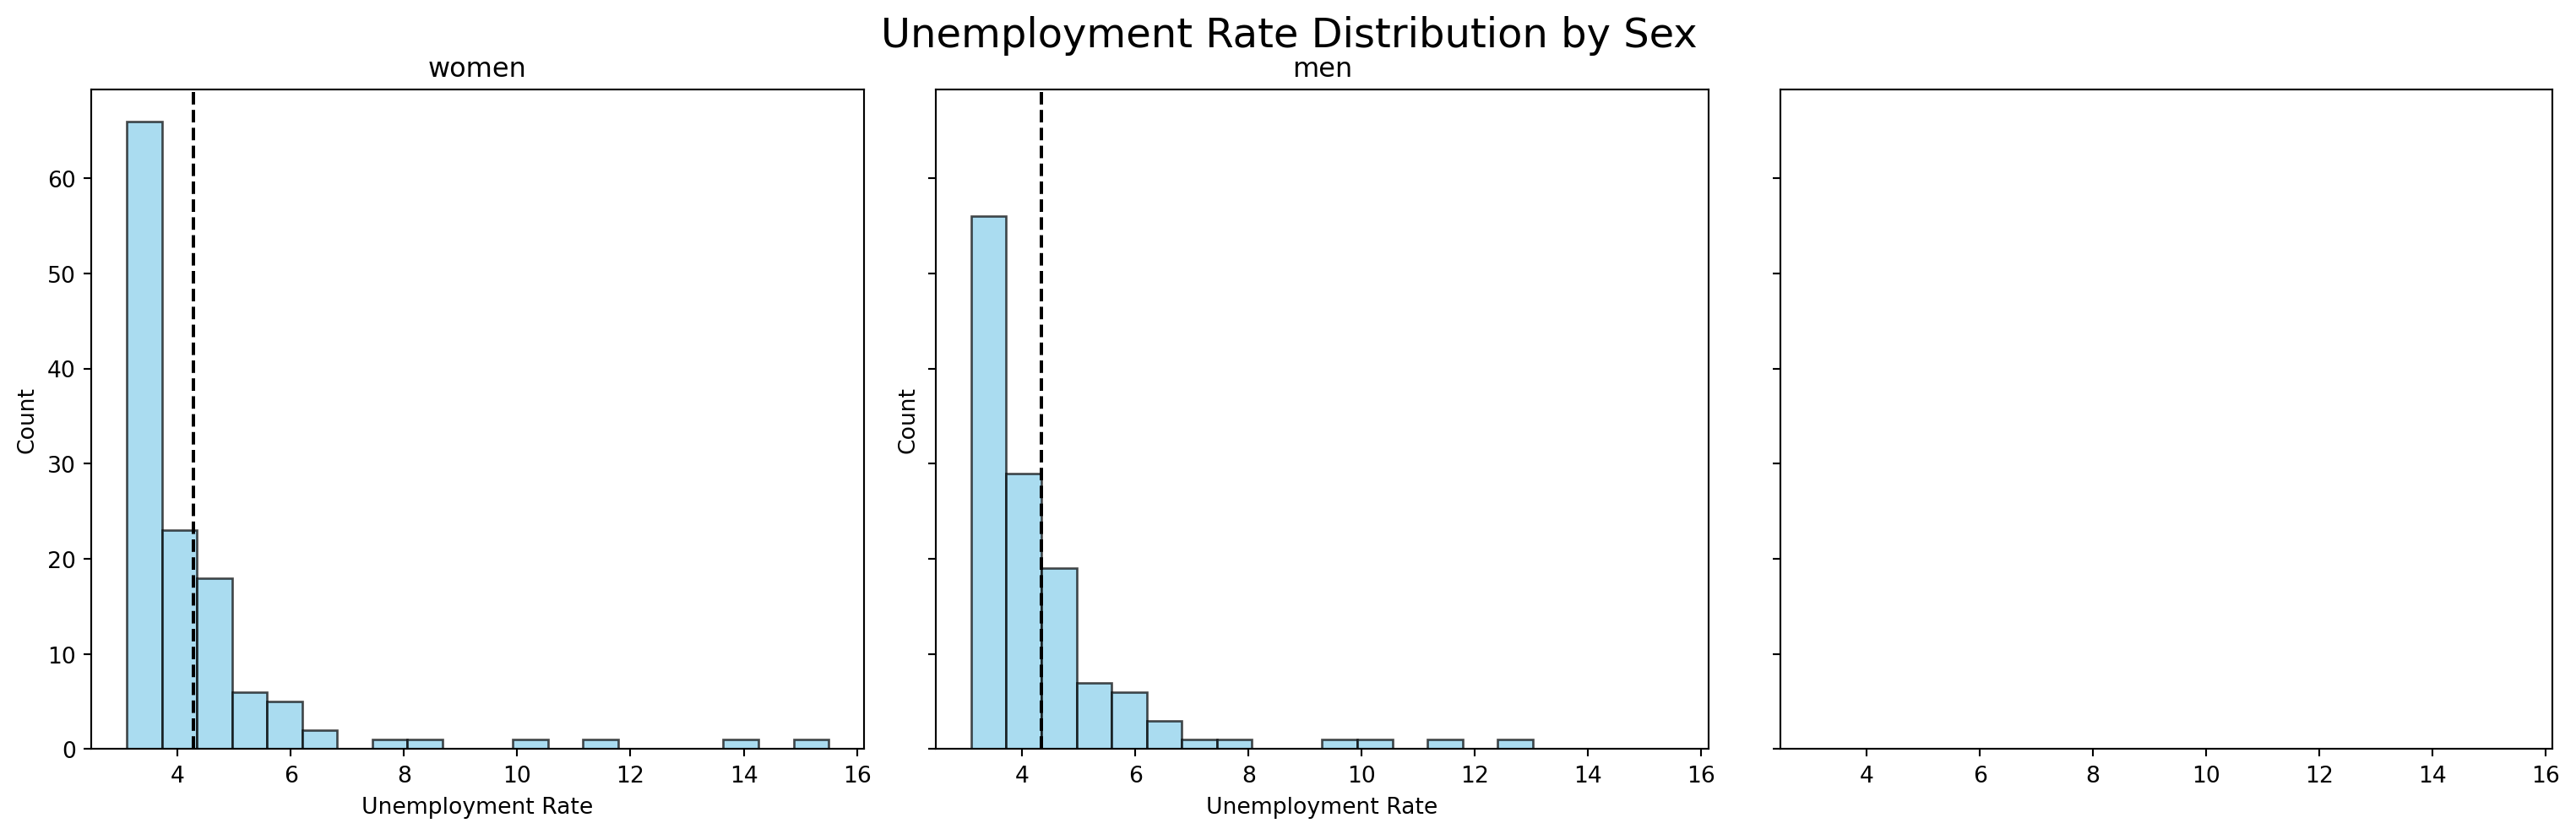

Unemployment Rate Distribution Histograms By Industry


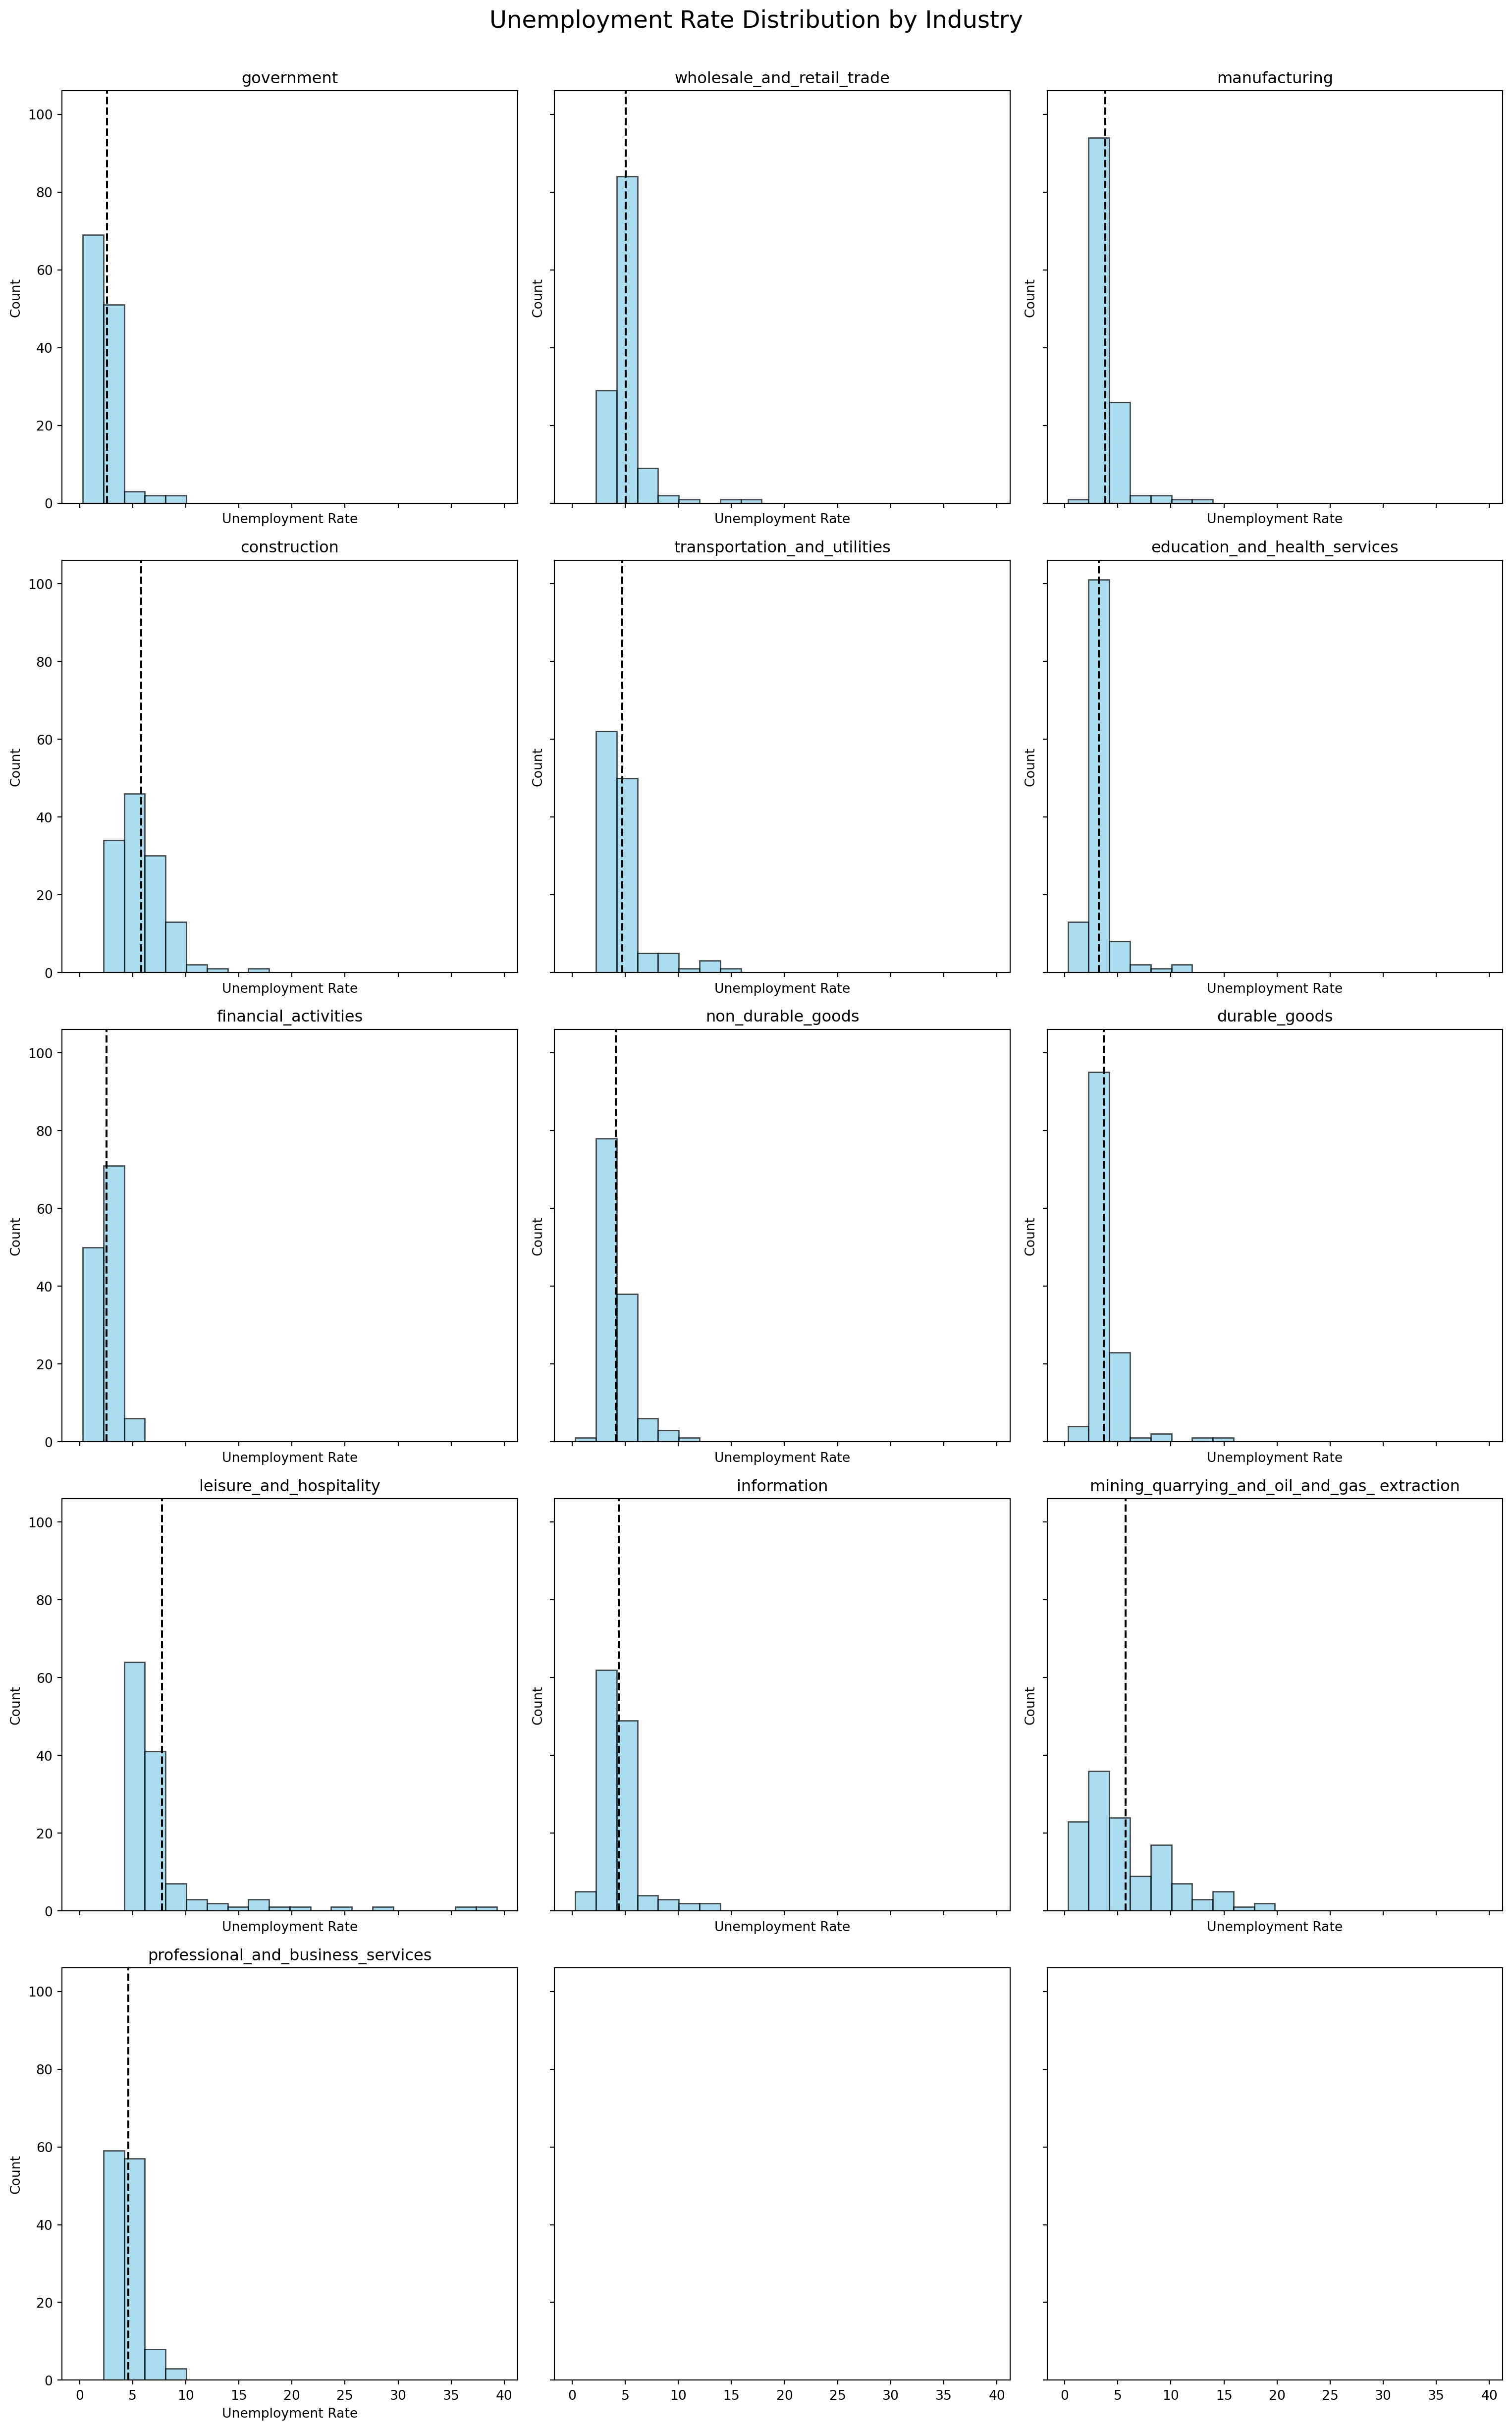

Unemployment Rate Distribution Histograms By Age


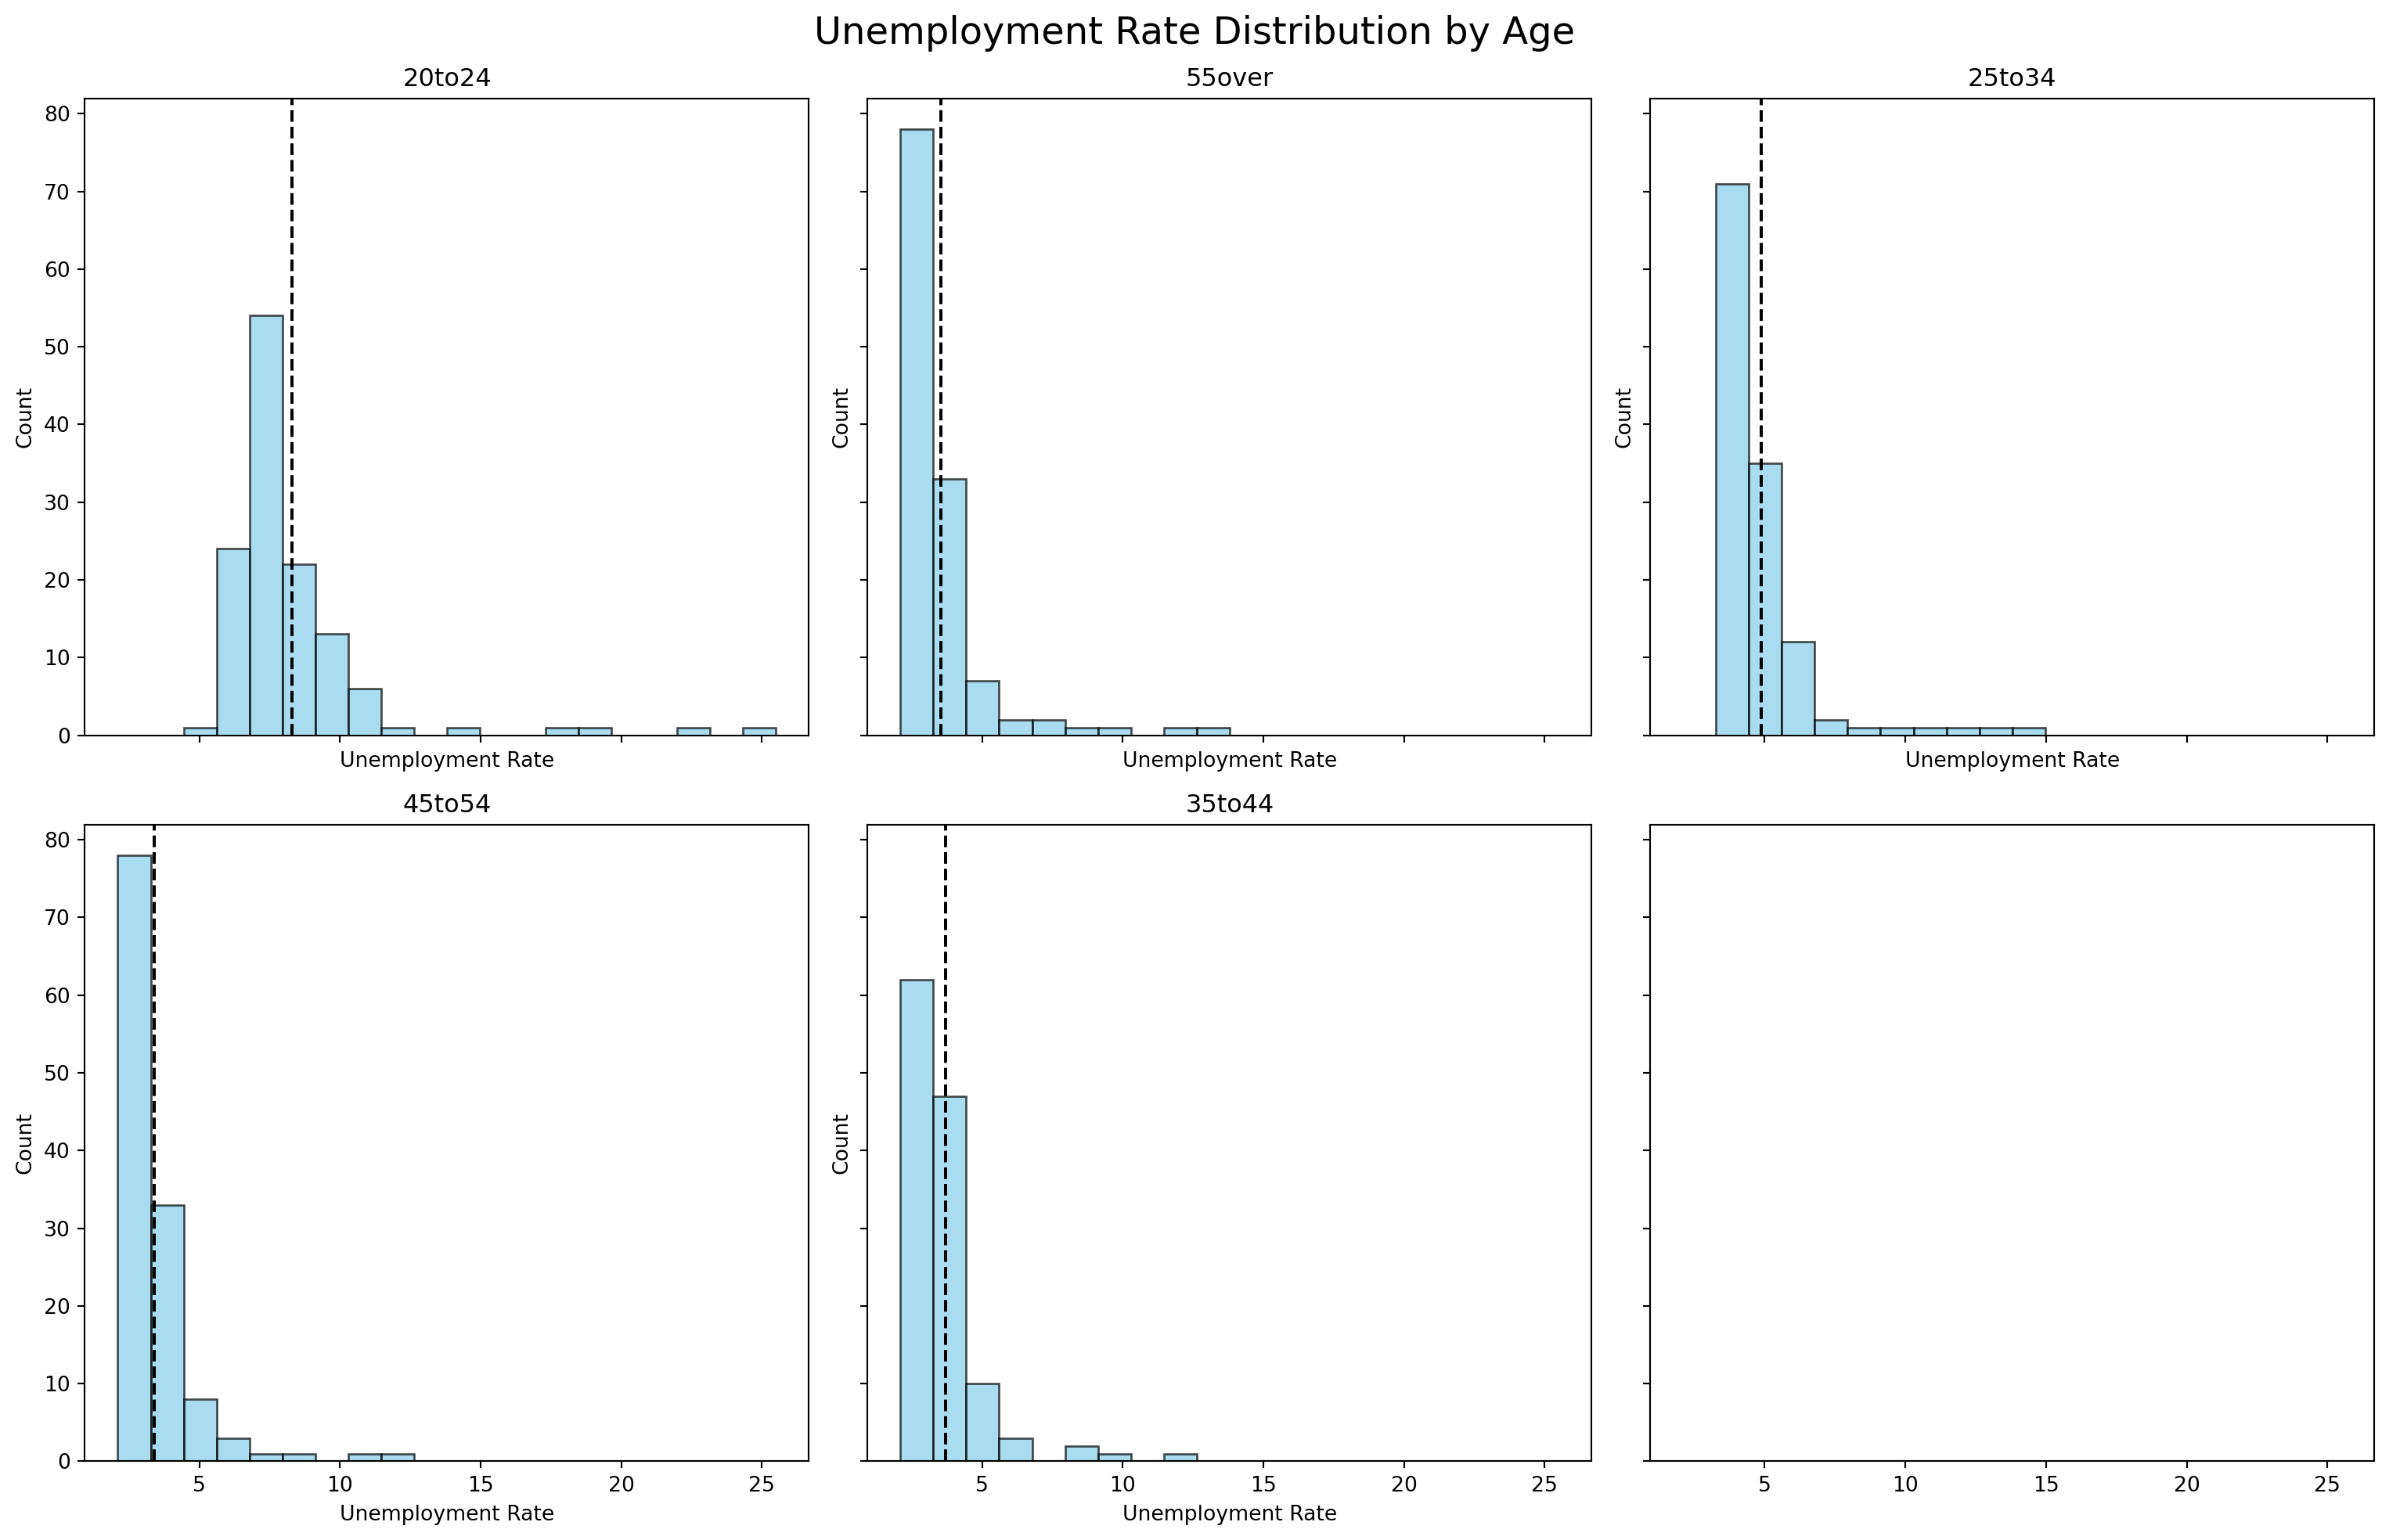

In [6]:
# Plot the distributions of unemployment stats of different demographic categories 

## 1. Plot the umemployment rate distributions by gender, age, industry, education_unattainment
import matplotlib.pyplot as plt
import numpy as np

def plot_hist(df_plot, demographic_type):
    unique_categories = df_plot[demographic_type].unique()
    num_unique_categories = len(unique_categories)
    ncol = 3
    nrow = np.int64(np.ceil(num_unique_categories/ncol))
    fig, axes = plt.subplots(ncols=ncol, nrows=nrow, sharex=True, sharey=True, figsize = (16,nrow*5))
    axes = axes.flatten()
    min_rate = df_plot['Unemployment_rate'].min()
    max_rate = df_plot['Unemployment_rate'].max()
    num_bins = 20 
    bins = np.linspace(min_rate, max_rate, num_bins + 1)
    for i, category in enumerate(unique_categories):
        ax = axes[i]
        vals = df_plot[df_plot[demographic_type]==category]['Unemployment_rate']
        ax.hist(vals, bins=bins, alpha=0.7, color='skyblue', edgecolor='black')
        ax.axvline(np.mean(vals), color = 'black', linestyle = "--")
        ax.set_title(category, fontsize=12)
        ax.set_xlabel('Unemployment Rate', fontsize=10)
        ax.set_ylabel('Count', fontsize=10)
    plt.tight_layout()
    plt.suptitle(f'Unemployment Rate Distribution by {demographic_type}', y=1.02, fontsize=18) 
    plt.show()

# Show the graphs except for the last one in order to add the ariticle label to the last grapph
for i in range(0, len(df_dic.keys())-1):
    df_plot = list(df_dic.values())[i]
    demographic_type = list(df_dic.keys())[i]
    print(f"Unemployment Rate Distribution Histograms By {demographic_type}")
    plot_hist(df_plot, demographic_type)


Unemployment Rate Distribution Histograms By Education_attainment


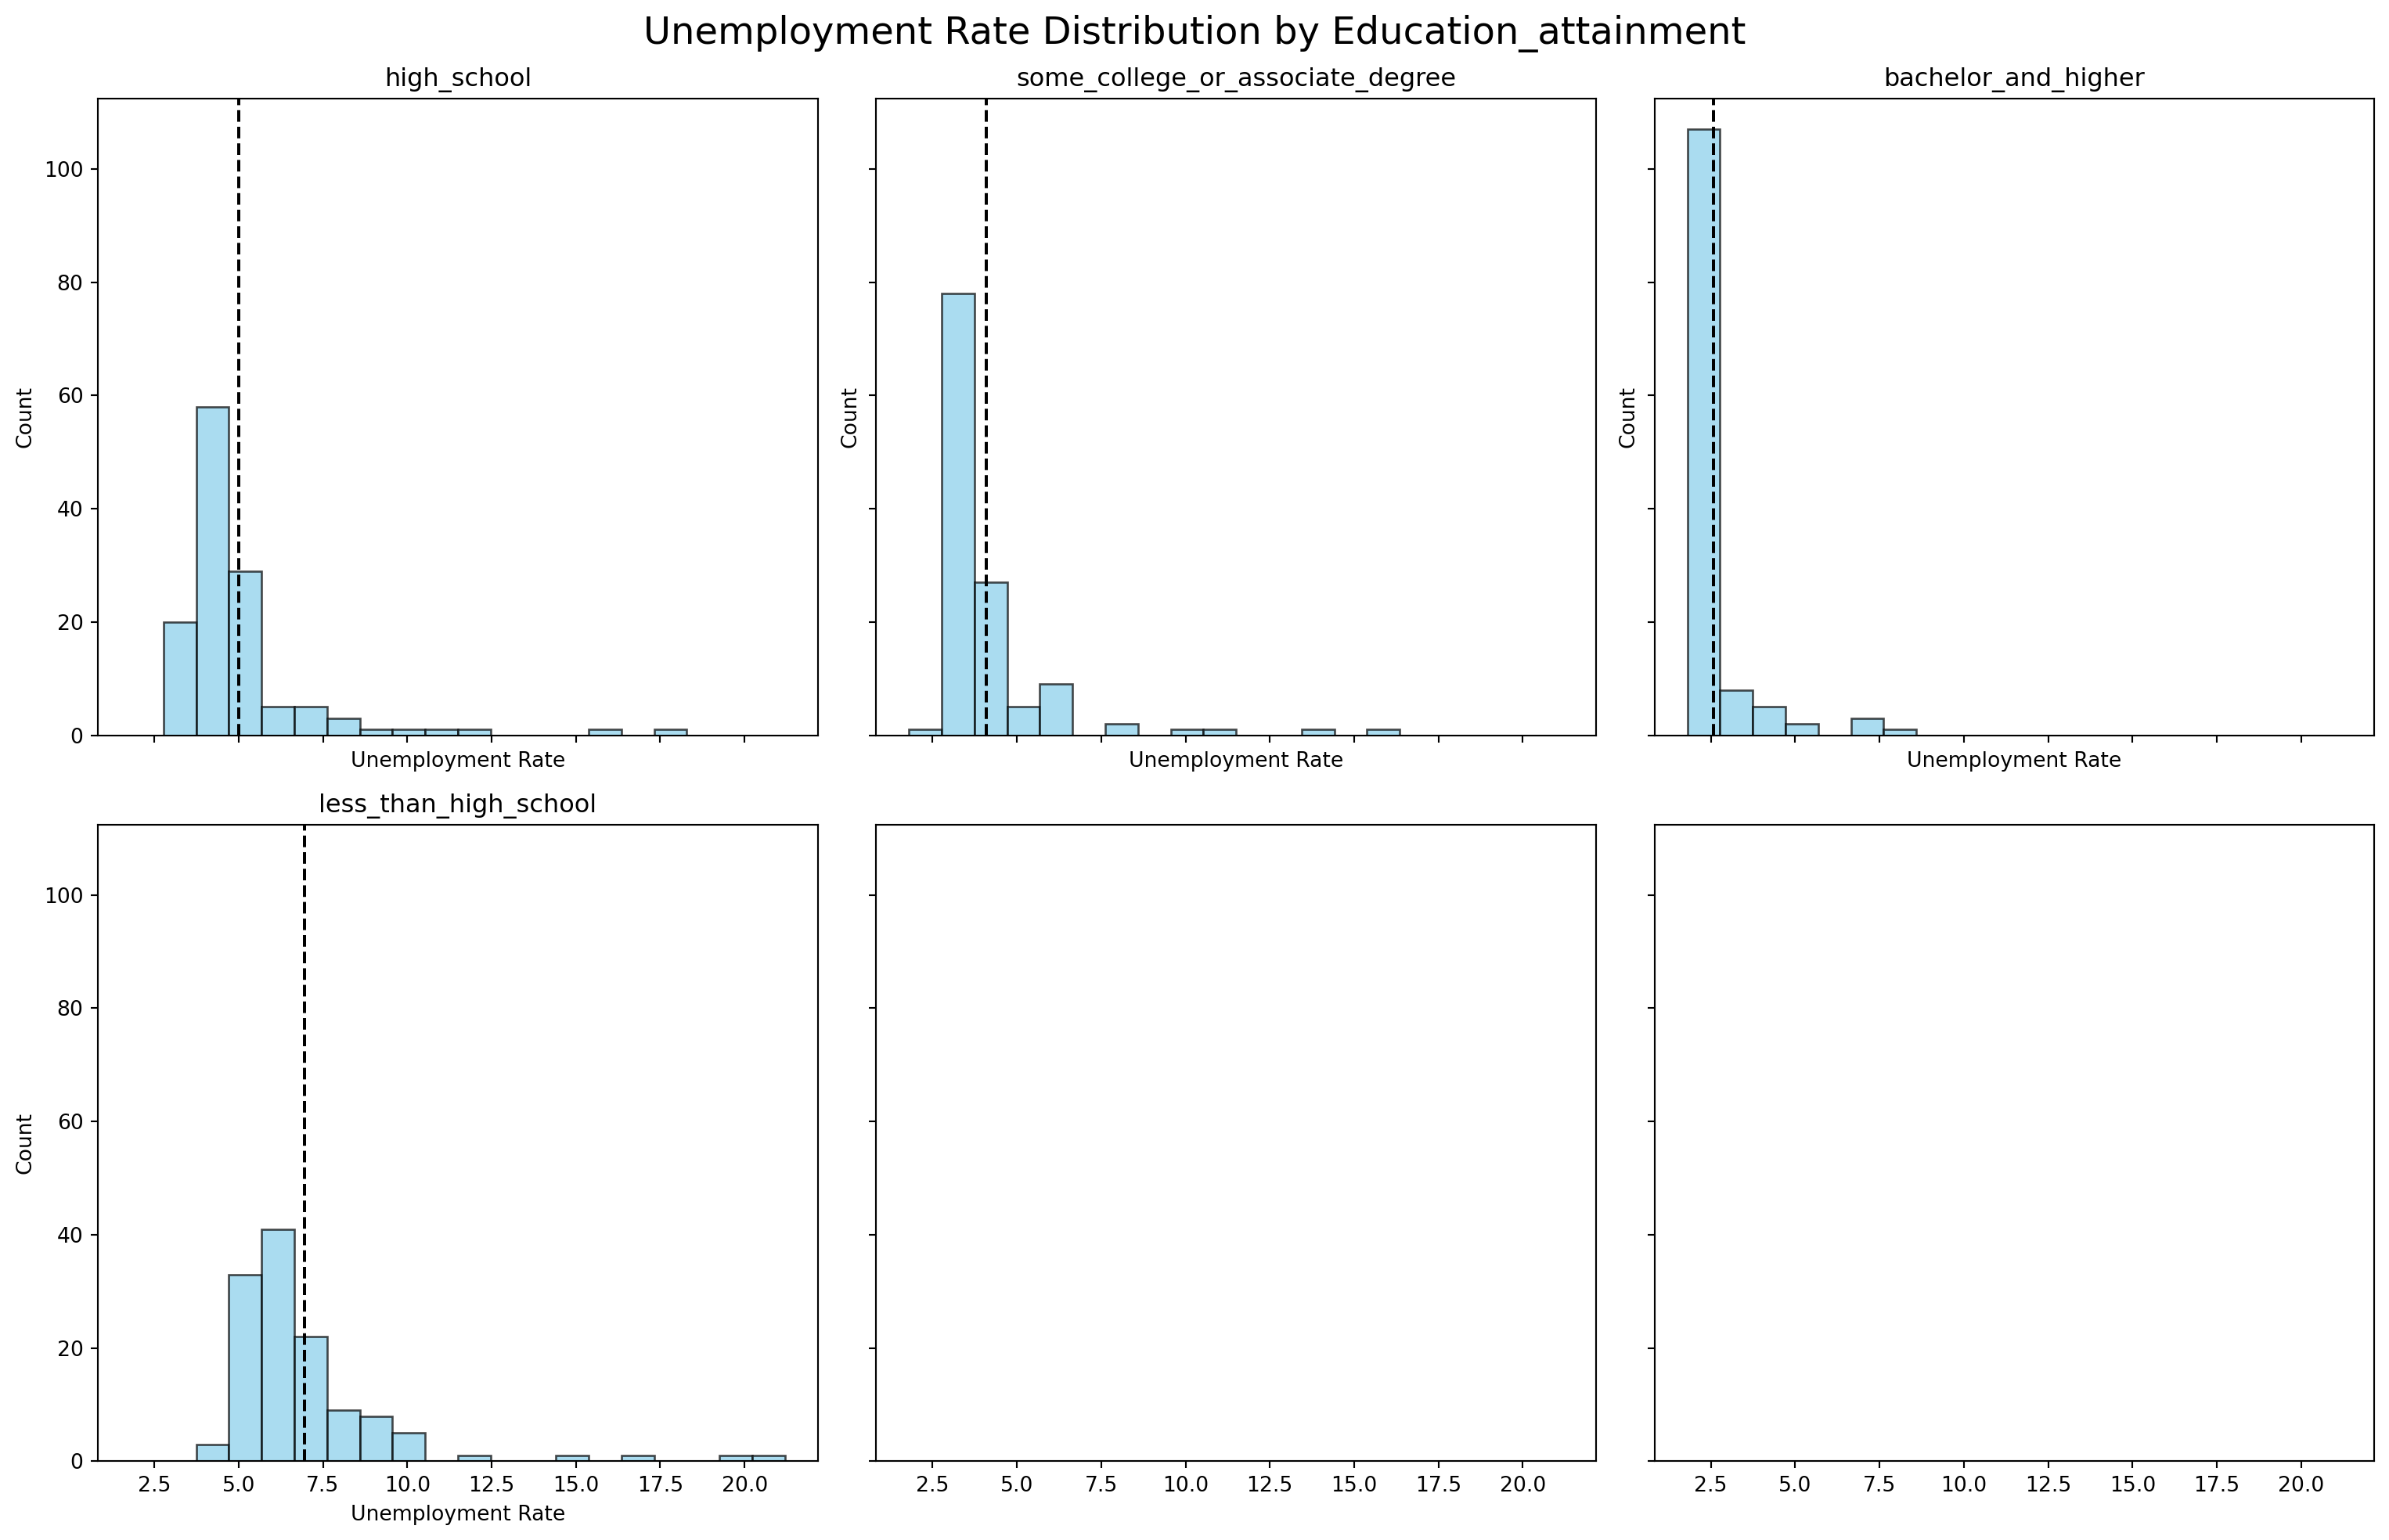

In [7]:
#| label: fig-histogram-unemployment-rate-demographics
#| fig-cap: Unemployment Rate Distributions By Demographics (2015-2025 statistics)
#| fig-alt: Histogram plots of the unemployment rate distributins by Age, Sex, Race, Industry and Education Attainment using 2015-2025 BLS data

## 2. Plot the overall umemployment rate 
## Display this graph separately from the preious chuck in order to add the aritcle label
df_plot = list(df_dic.values())[len(df_dic.keys())-1]
demographic_type = list(df_dic.keys())[len(df_dic.keys())-1]
print(f"Unemployment Rate Distribution Histograms By {demographic_type}")
plot_hist(df_plot, demographic_type)

BLS data from 2015–2025 indicate that the Black or African American population experienced the highest average unemployment rate (7.5%), primarily within the 5–10% range. Gender differences are minimal, with both averaging around 5%, though rates are slightly higher for men. Among industries, Leisure and Hospitality recorded the highest unemployment (10%) with a long-tail distribution, followed by Agriculture (5–11%) and moderate variability. Construction and Mining/Oil & Gas exhibit similar but marginally lower patterns. The 22–24 age group stands out with significantly elevated unemployment—averaging 7% and predominantly above 5%—while other age groups display lower and more uniform rates. Financial Activities show the lowest and most stable unemployment, consistently under 5%. Individuals without a high school diploma face high and variable unemployment, averaging 7% with a long-tail skew. These patterns suggest that young adults (22–24), Black or African Americans without college degrees, and those employed in Leisure, Construction, or Mining sectors are disproportionately affected by higher unemployment. (@fig-histogram-unemployment-rate-demographics).

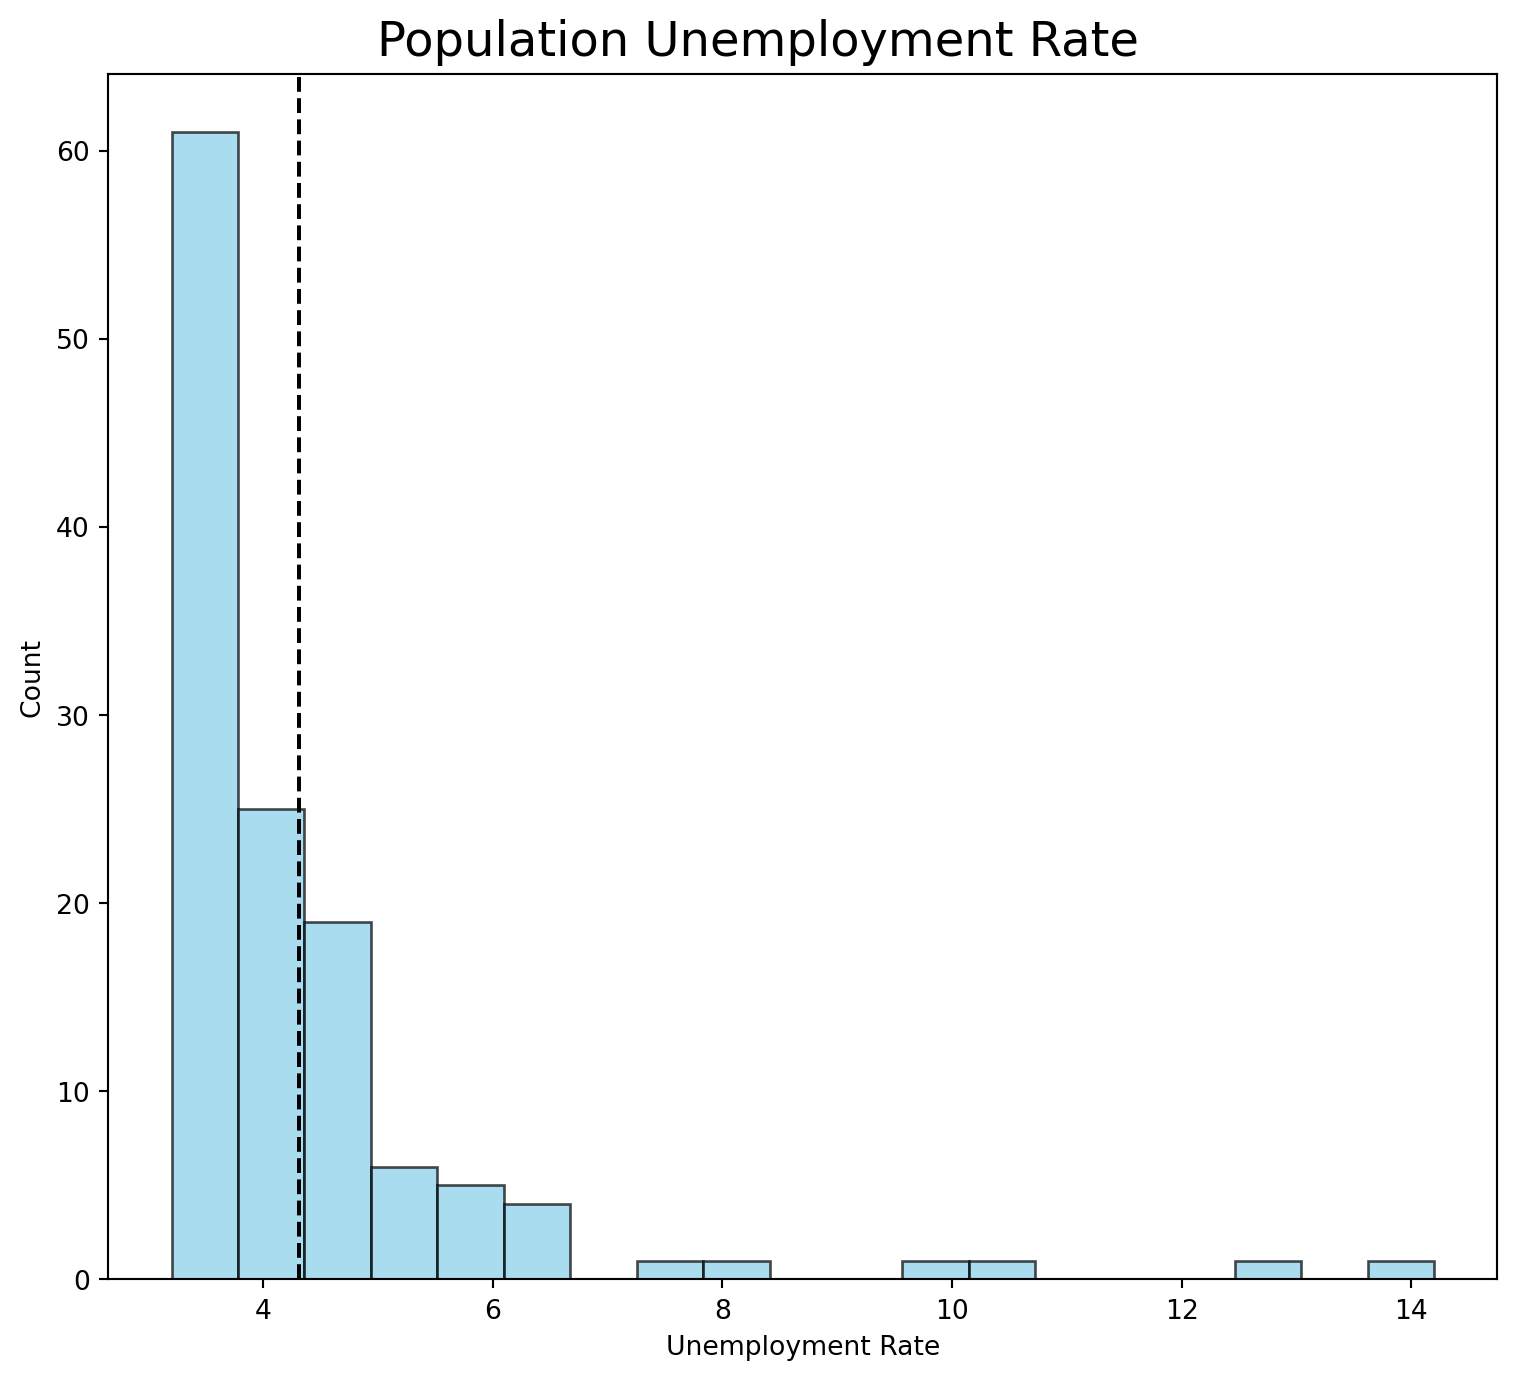

In [8]:
#| label: fig-histogram-unemployment-rate
#| fig-cap: Overall Population Unemployment Rate Distributions (2015-2025 statistics)
#| fig-alt: Histogram plot of the overall population unemployment rate distributions using 2015-2025 BLS data
min_rate = df_overall_long['Unemployment_rate'].min()
max_rate = df_overall_long['Unemployment_rate'].max()
num_bins = 20
bins = np.linspace(min_rate, max_rate, num_bins)
fig, ax = plt.subplots(figsize = (8, 7))
ax.hist(df_overall_long['Unemployment_rate'], bins=bins, alpha=0.7, color='skyblue', edgecolor='black')
ax.axvline(np.mean(df_overall_long['Unemployment_rate']), color="black", linestyle="--")
ax.set_xlabel("Unemployment Rate", fontsize=10)
ax.set_ylabel("Count", fontsize=10)
plt.tight_layout()
plt.suptitle("Population Unemployment Rate", y =1.02, fontsize=18)
plt.show()

According to BLS data from 2015–2025, the overall population unemployment rate averaged slightly above 4%, with the majority of observations concentrated between 2% and 5% and exhibiting relatively low variability (@fig-histogram-unemployment-rate).

### Unemployment Rates of Differenet Industries

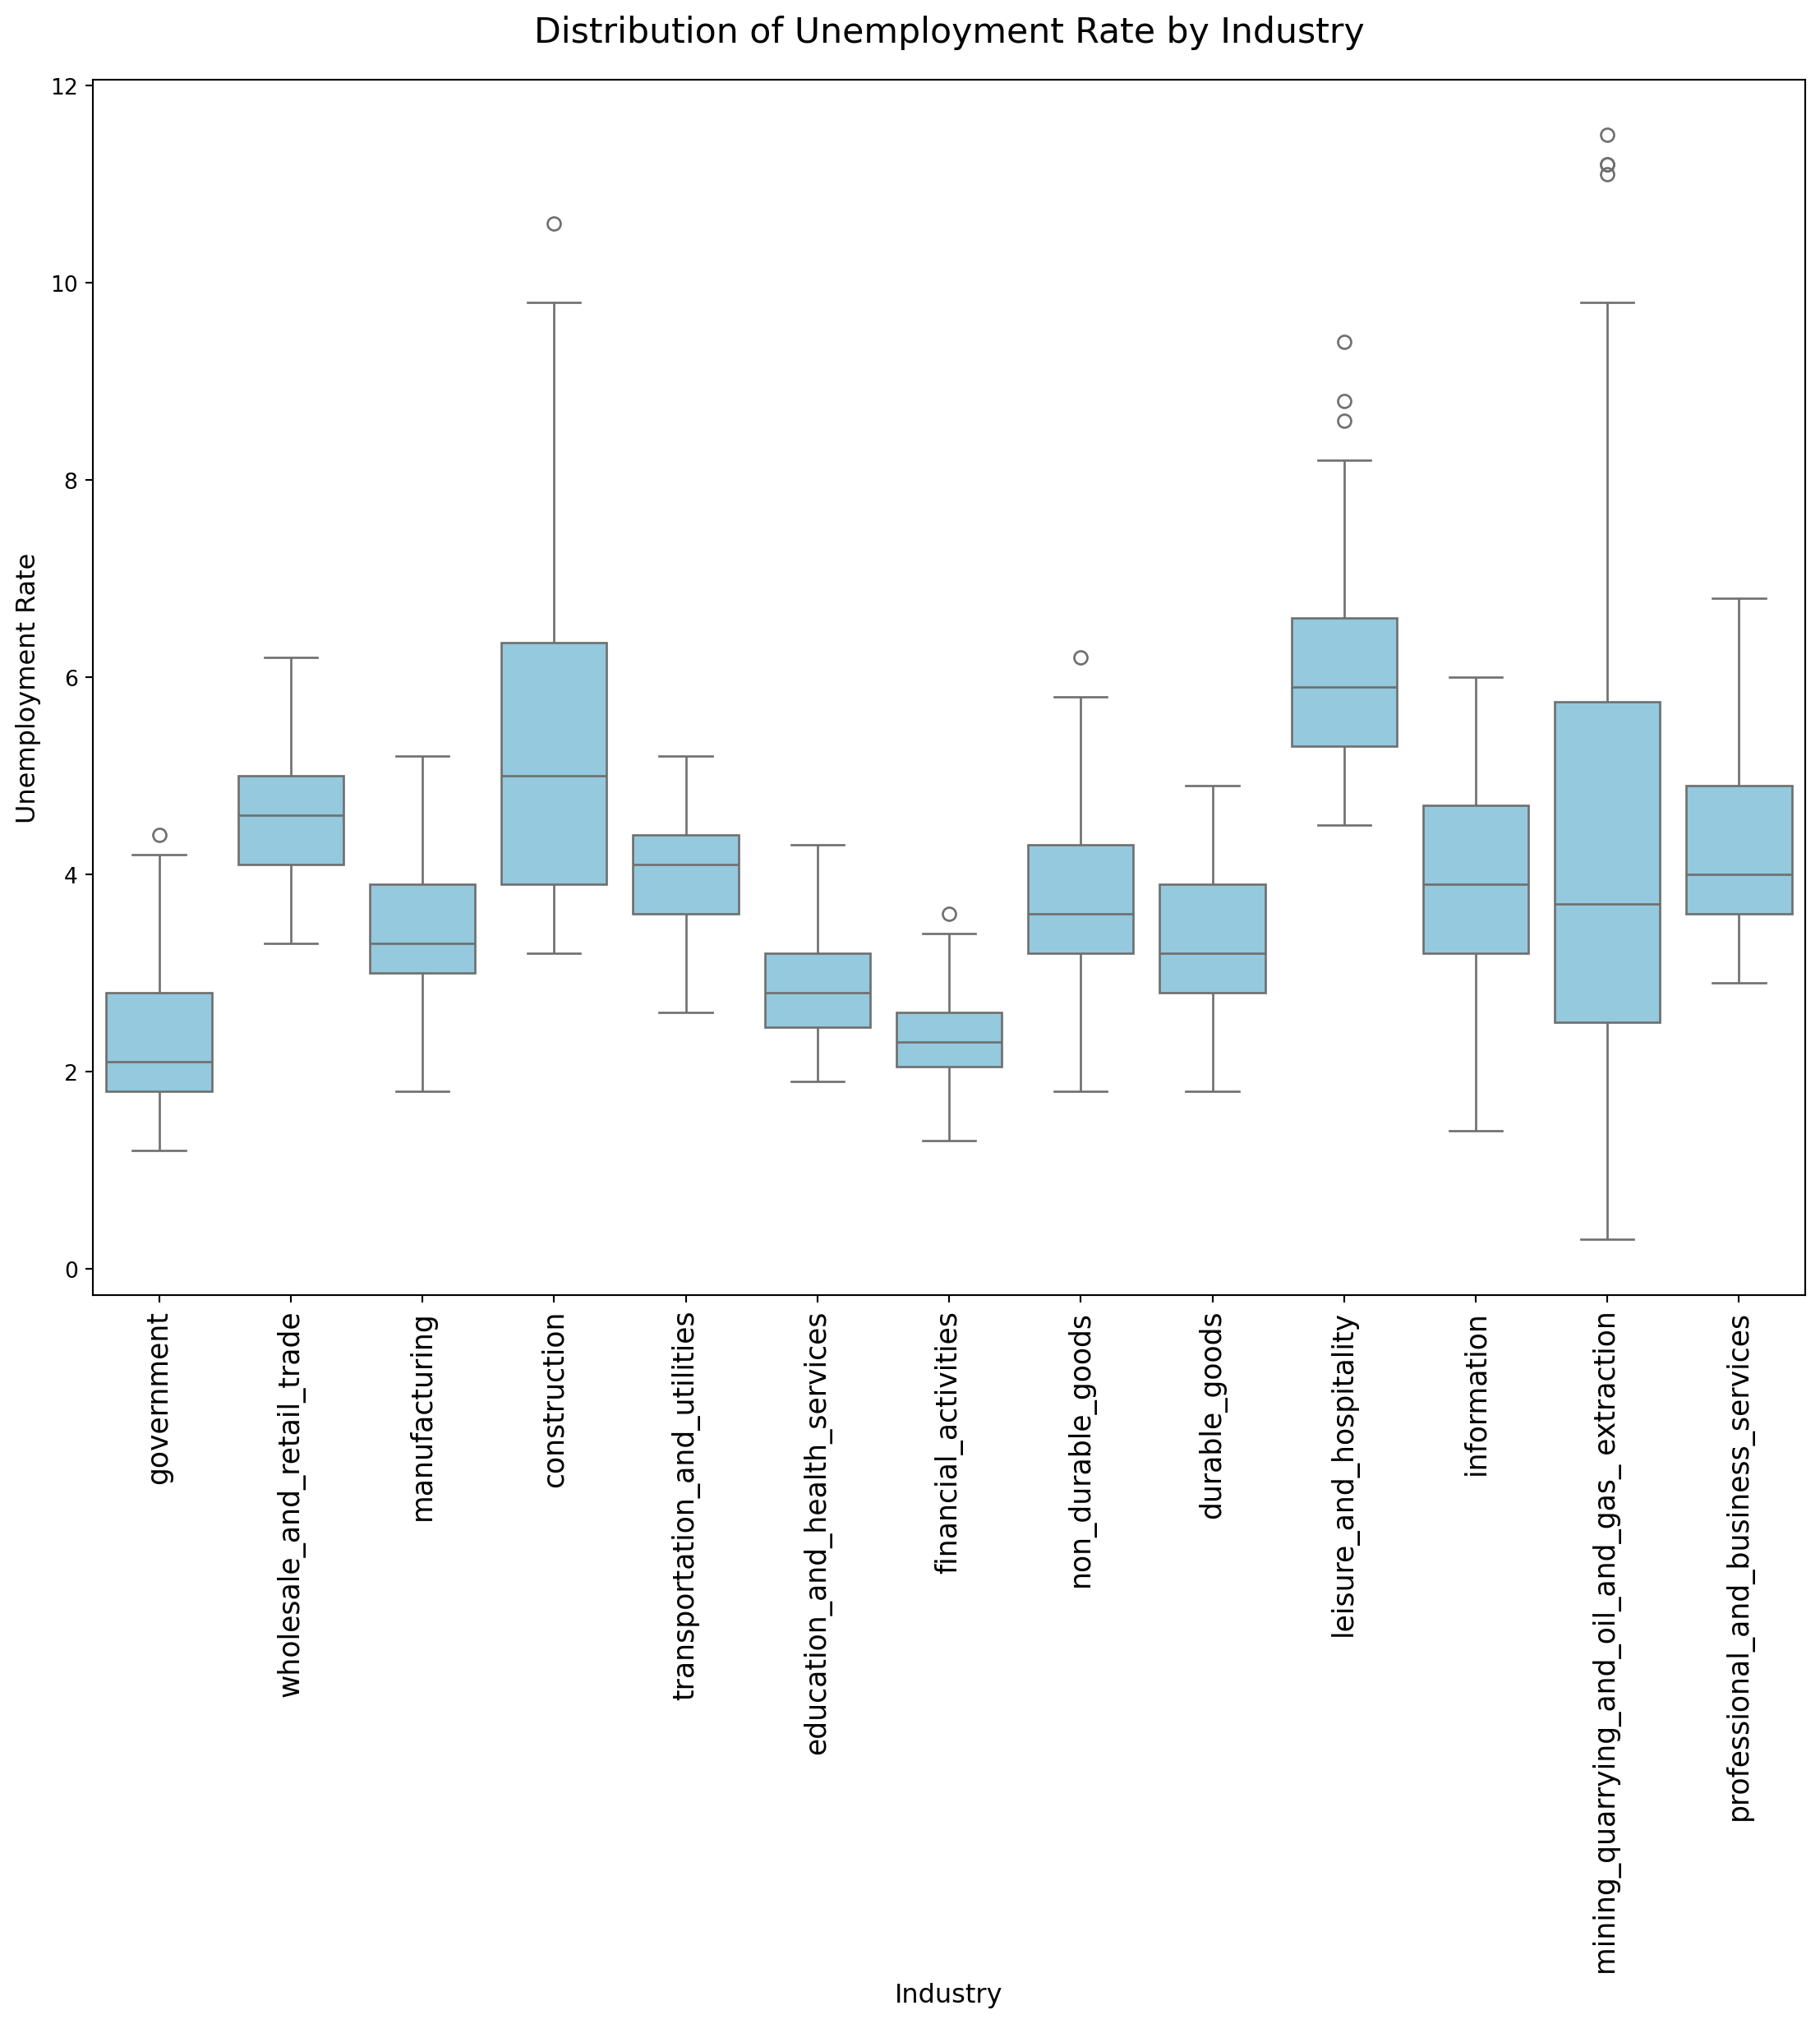

In [9]:
#| label: fig-boxplot-unemployment-rate-industry
#| fig-cap: Unemployment Rate Distributions By Industries (2015-2025 statistics)
#| fig-alt: Boxplot of the industry unemployment rates distributions using 2015-2025 BLS data

# Boxplot for unemployment rate by industry
import seaborn as sns
df_industry = df_dic['Industry']
df_industry = df_industry[~df_industry['Year'].isin([2020,2021])]
fig, ax = plt.subplots(figsize = (14,10))
sns.boxplot(df_industry, x="Industry", y="Unemployment_rate", color='skyblue', ax=ax)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Industry', fontsize=12)
ax.set_ylabel('Unemployment Rate', fontsize=12)
ax.set_title('Distribution of Unemployment Rate by Industry', y = 1.02, fontsize=16)
ax.tick_params(axis='x', labelsize=13, rotation=90)

The boxplot illustrates notable variation in unemployment rates across industries. "Agricultural, mining/oil/gas extraction" and "Construction" industries exhibit the highest variation and upper extremes, indicating greater instability in employment. Due to the volatility and unpredictivity as a result of seasonlity, these two categories are going to be excluded from our analysis. In contrast, "Government", "Financial services", and "Education/health services" show consistently low and stable unemployment rates, with narrower interquartile ranges and fewer outliers. These patterns suggest structural differences in labor market vulnerability across sectors. (@fig-boxplot-unemployment-rate-industry).


## PGM
We posit that unemployment vulnerability is driven by structural inequalities within the labor market, particularly those rooted in demographic and industrial dimensions. Demographic disparities are represented by variables such as race, age, and educational attainment and industry; sex is excluded from the analysis due to prior findings indicating minimal impact on unemployment rates. Establishing a baseline unemployment level is a necessary step before assessing the marginal effects of these demographic and industrial factors.

### Race model - Baseline unemployment rate distribution 
Figure 3 illustrates that the population unemployment rate is right-skewed, suggesting that the Log-Normal distribution is an appropriate model. We are going to estimate the parameters of a Log-Normal distribution from the population distribution data using MLE. ($\sigma$, $\text{loc}$, and $\text{scale}$).


Fitted Log-Norm Distribution Parameters:
  Shape parameter 'alpha'): 9.92
  Location parameter (loc): 3.20
  Scale parameter (scale): 0.03


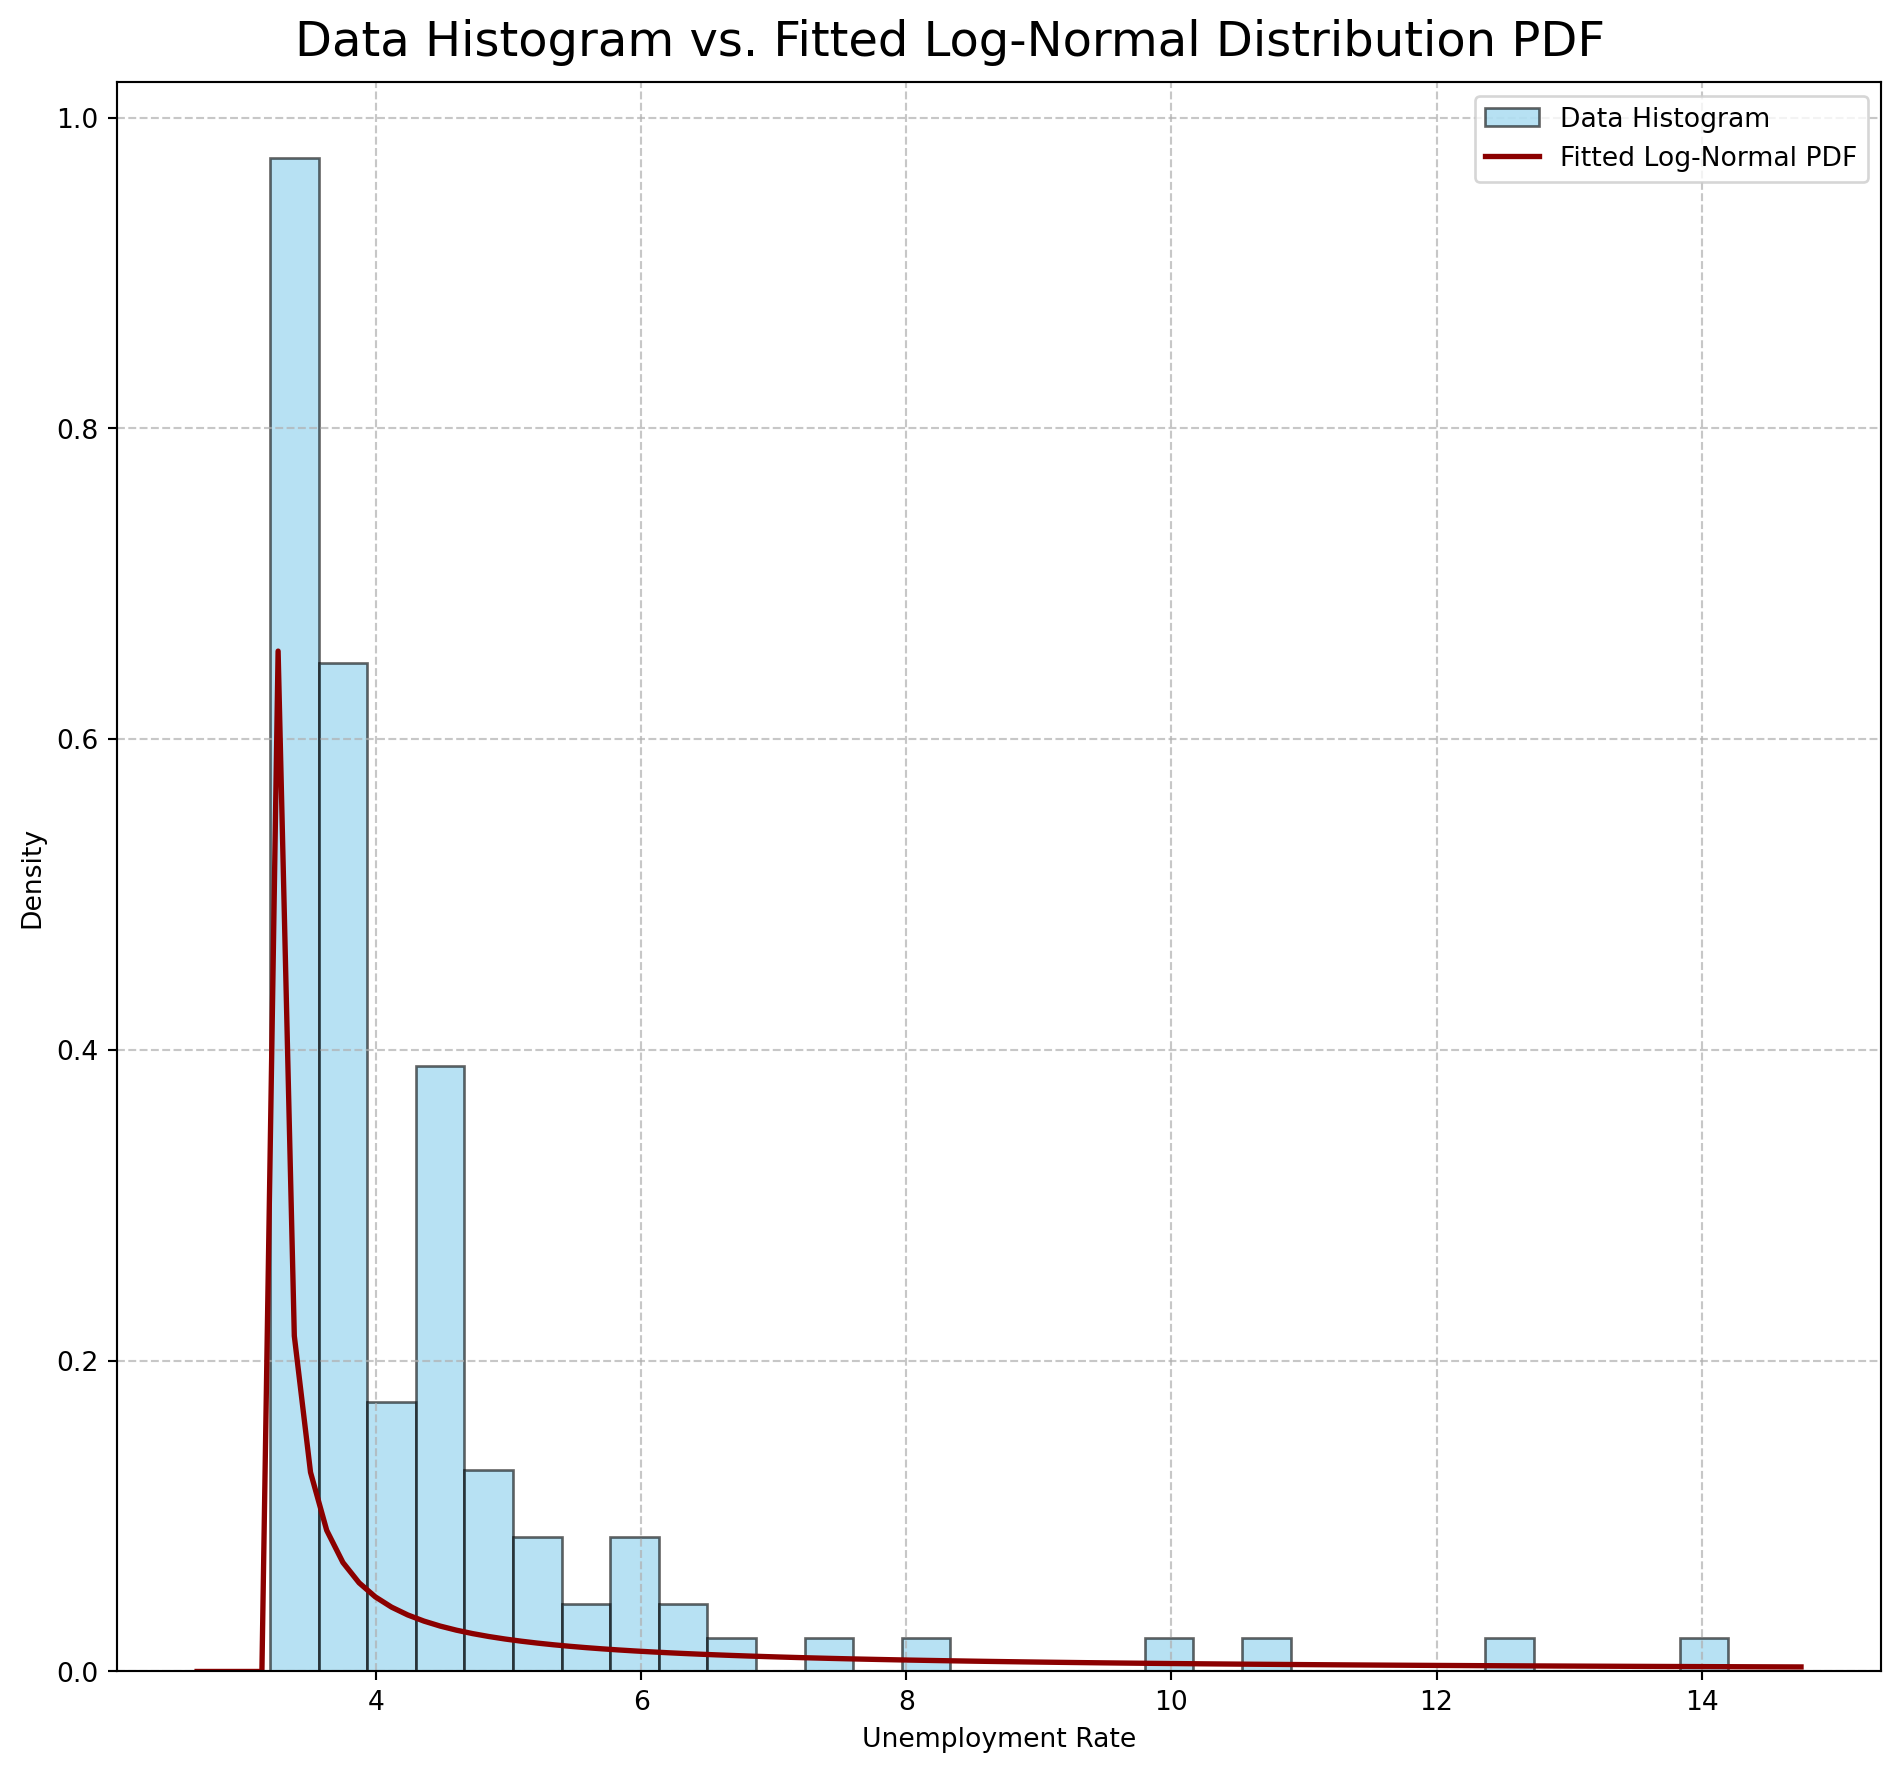

In [10]:
#| label: fig-histogram-lognorm
#| fig-cap: Unmployment Rate Histogram vs. Fitted Log-Norm PDF
#| fig-alt: Plot the histogram of unemployment rate data and overlay the Probability Density Function (PDF) of the fitted log-norm distribution.

# Fit log-norm distribution using population unemployment rate data
from scipy.stats import lognorm, kstest, skew 

## Get the unemployment_rate data that is not NA, convert to array
data_to_fit = df_overall_long[~np.isnan(np.array(df_overall_long['Unemployment_rate']))]['Unemployment_rate']

sigma_fit, loc_fit, scale_fit = lognorm.fit(data_to_fit) # Fit log-normal distribution

# Print the estimated parameters
print(f"\nFitted Log-Norm Distribution Parameters:")
print(f"  Shape parameter 'alpha'): {sigma_fit:.2f}")
print(f"  Location parameter (loc): {loc_fit:.2f}")
print(f"  Scale parameter (scale): {scale_fit:.2f}")

# Visualize the fit
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 9))
## Histogram of the unemployment data
ax.hist(data_to_fit, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Data Histogram')
## Fitted log-norm pdf
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = lognorm.pdf(x, sigma_fit, loc=loc_fit, scale=scale_fit)
ax.plot(x, p, 'darkred', lw=2, label='Fitted Log-Normal PDF')
ax.set_xlabel('Unemployment Rate', fontsize=10)
ax.set_ylabel('Density', fontsize=10)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.suptitle("Data Histogram vs. Fitted Log-Normal Distribution PDF", y=1.02, fontsize=18)
plt.show()

By overlaying the smooth PDF curve on top of original data's histogram, we can visualize that the Log-Normal distribution matches the distribution of the actual data. The peak of the PDF align with the peak of the histogram. The spread of the PDF roughly match the spread of the data, including the tail (@fig-histogram-lognorm).
Now we need to use Kolmogorov-Smirnov Test to test Goodness-of-fit with the original data and estimated parameters, then examine the p value. 


In [11]:
# KS goodness of fit test
d_statistic, p_value = kstest(data_to_fit, lambda x: lognorm.cdf(x, sigma_fit, loc=loc_fit, scale=scale_fit)) 
print(f"\nKolmogorov-Smirnov Test Results:")
print(f"  D-statistic: {d_statistic:.4f}")
print(f"  P-value: {p_value:.4f}")


Kolmogorov-Smirnov Test Results:
  D-statistic: 0.4592
  P-value: 0.0000


With $p$-value < 0.05, we can't reject the hypothesis that the distribution does not come from the Log-Normal distribution, suggesting Log-Normal is not a good fit for the data. Next, explore other right-skewed distributions - Gamma distribution or the Weibull distribution.


Fitted Gamma Distribution Parameters:
  Shape parameter 'alpha': 0.45
  Location parameter 'loc': 3.20
  Scale parameter 'scale'): 1.36


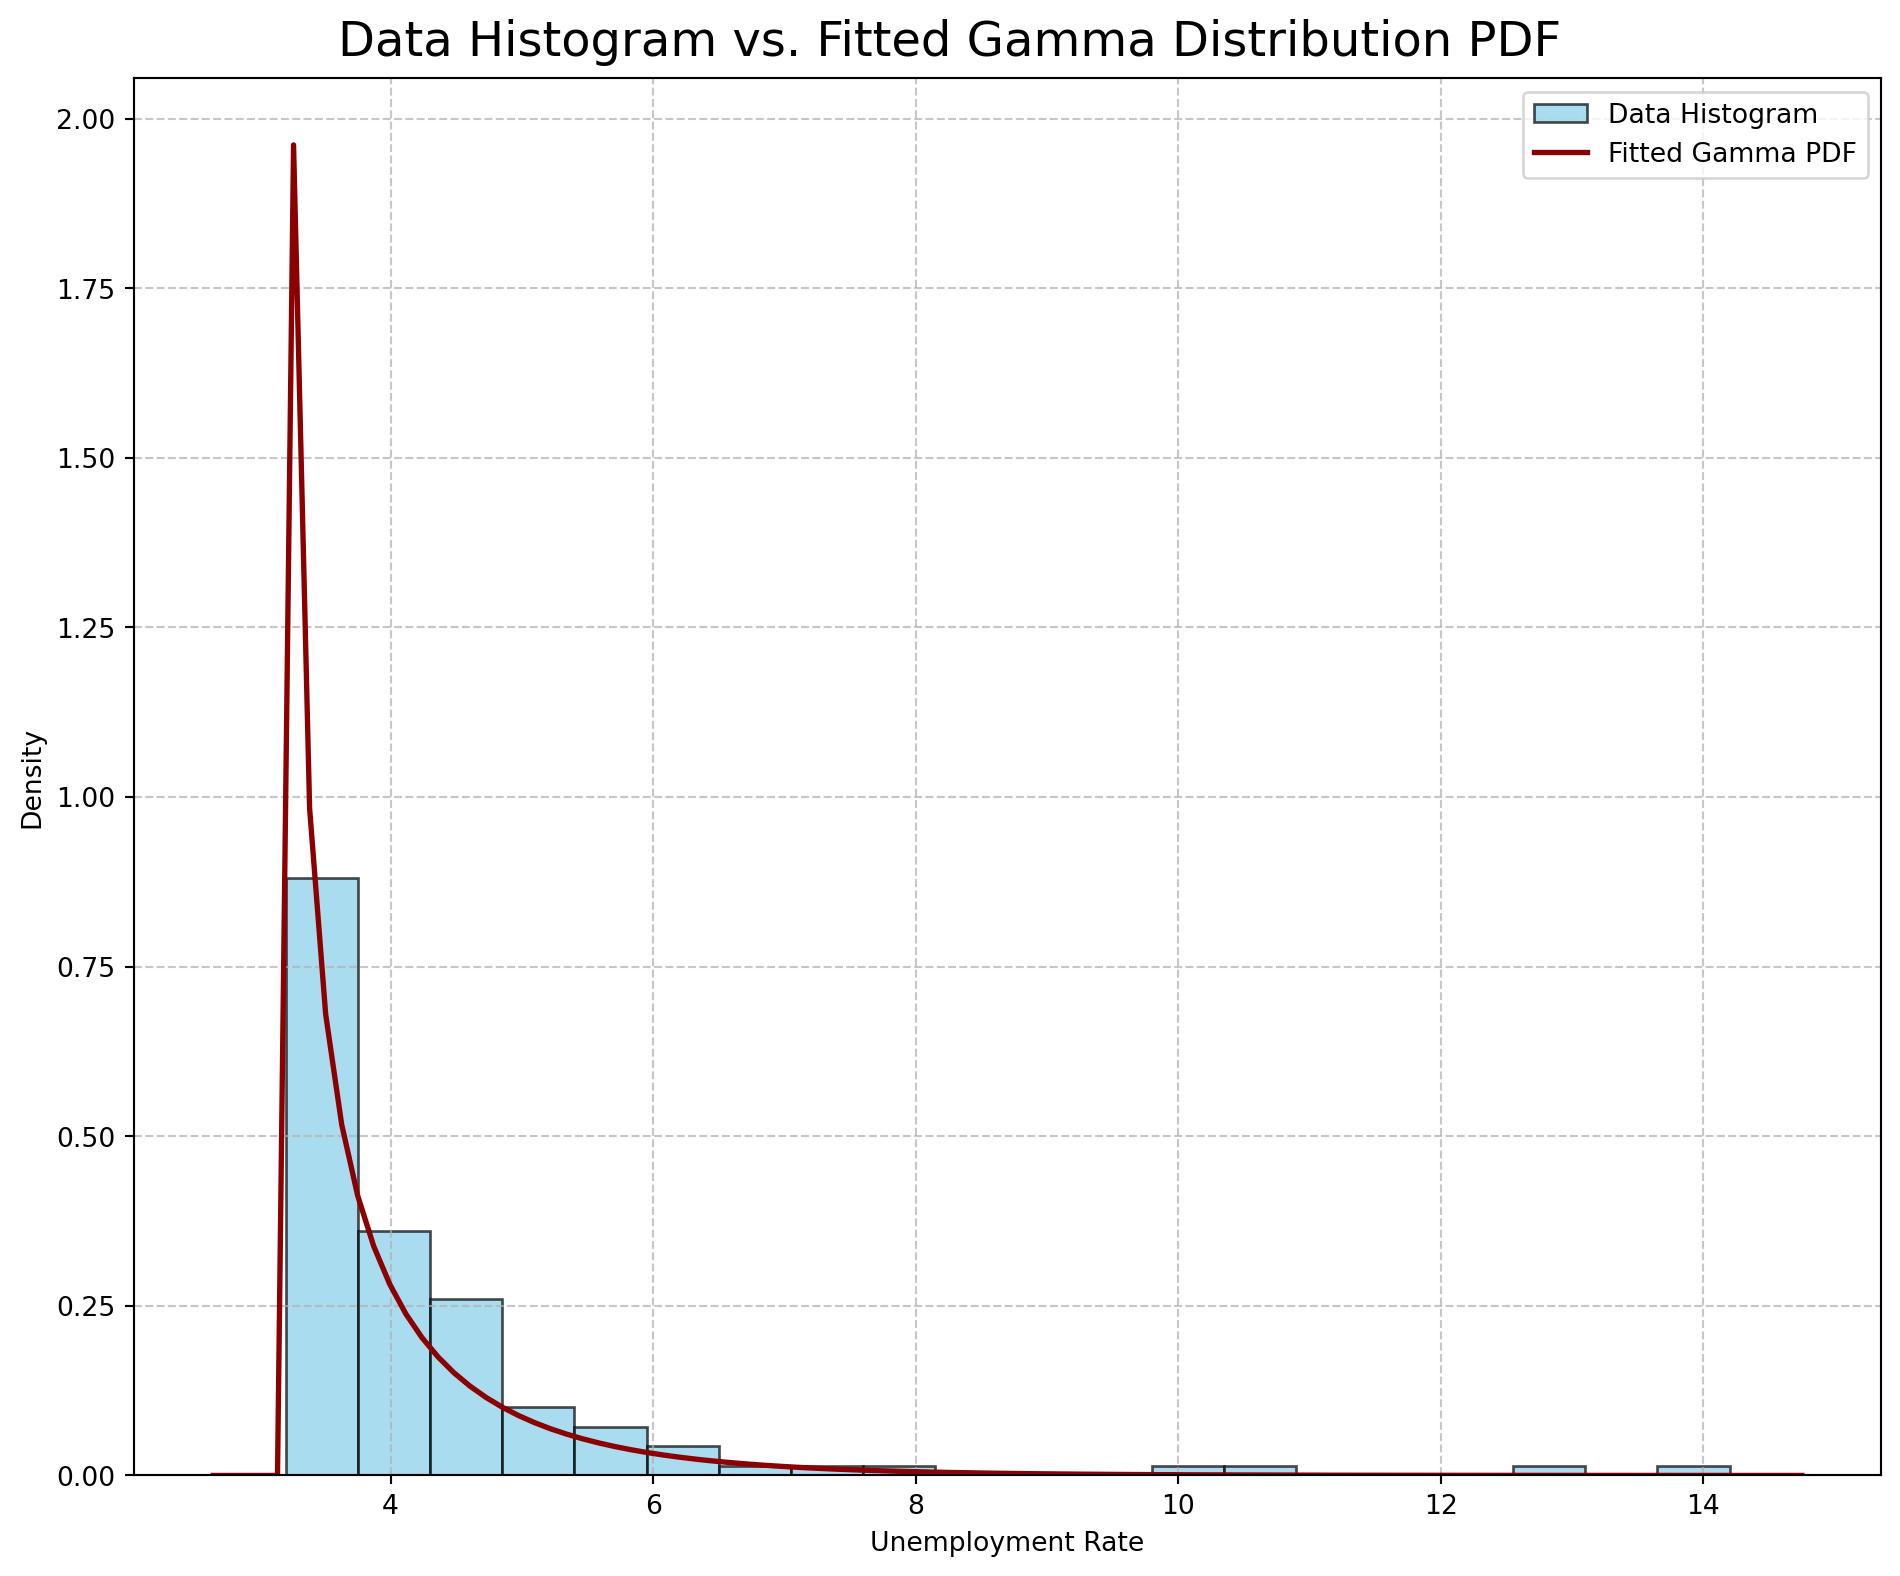

In [12]:
#| label: fig-histogram-gamma
#| fig-cap: Unmployment Rate Histogram vs. Fitted Gamma PDF
#| fig-alt: Plot the histogram of unemployment rate data and overlay the Probability Density Function (PDF) of the fitted Gamma distribution.

# Fit gamma distribution using MLE
from scipy.stats import gamma, skew, kstest
alpha_fit, loc_fit, scale_fit = gamma.fit(data_to_fit) # fit gamma distribution

# Print the estimated parameters
print(f"\nFitted Gamma Distribution Parameters:")
print(f"  Shape parameter 'alpha': {alpha_fit:.2f}")
print(f"  Location parameter 'loc': {loc_fit:.2f}")
print(f"  Scale parameter 'scale'): {scale_fit:.2f}")

# Visualize the fit
fig, ax = plt.subplots(1, 1, figsize = (10, 8))
## Histogram of the unemployment data
ax.hist(data_to_fit, bins = 20, density=True, color='skyblue', alpha= 0.7, edgecolor='black', label = 'Data Histogram')
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)

## Plot fitted gamma pdf
p = gamma.pdf(x, alpha_fit, loc=loc_fit, scale=scale_fit)
ax.plot(x, p, 'darkred', lw=2, label='Fitted Gamma PDF')
ax.set_xlabel('Unemployment Rate', fontsize=10)
ax.set_ylabel('Density', fontsize=10)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.suptitle("Data Histogram vs. Fitted Gamma Distribution PDF", y=1.02, fontsize=18)
plt.show()

Although visually the Gamma distribution matches the shape and spread of the actual data. (@fig-histogram-gamma), we need to
use KS Test to test Goodness-of-fit by examining the p value. 

In [13]:
# Fit the gamma 
d_statistic, p_value = kstest(data_to_fit, lambda x: gamma.cdf(x, alpha_fit, loc=loc_fit, scale=scale_fit))
print(f"\nKolmogorov-Smirnov Test Results:")
print(f"  D-statistic: {d_statistic:.4f}")
print(f"  P-value: {p_value:.4f}")


Kolmogorov-Smirnov Test Results:
  D-statistic: 0.2699
  P-value: 0.0000


Again, with $p$-value < 0.05, we can not confidently say that the data comes from the Gamma distribution. Next, explore Weibull distribution.

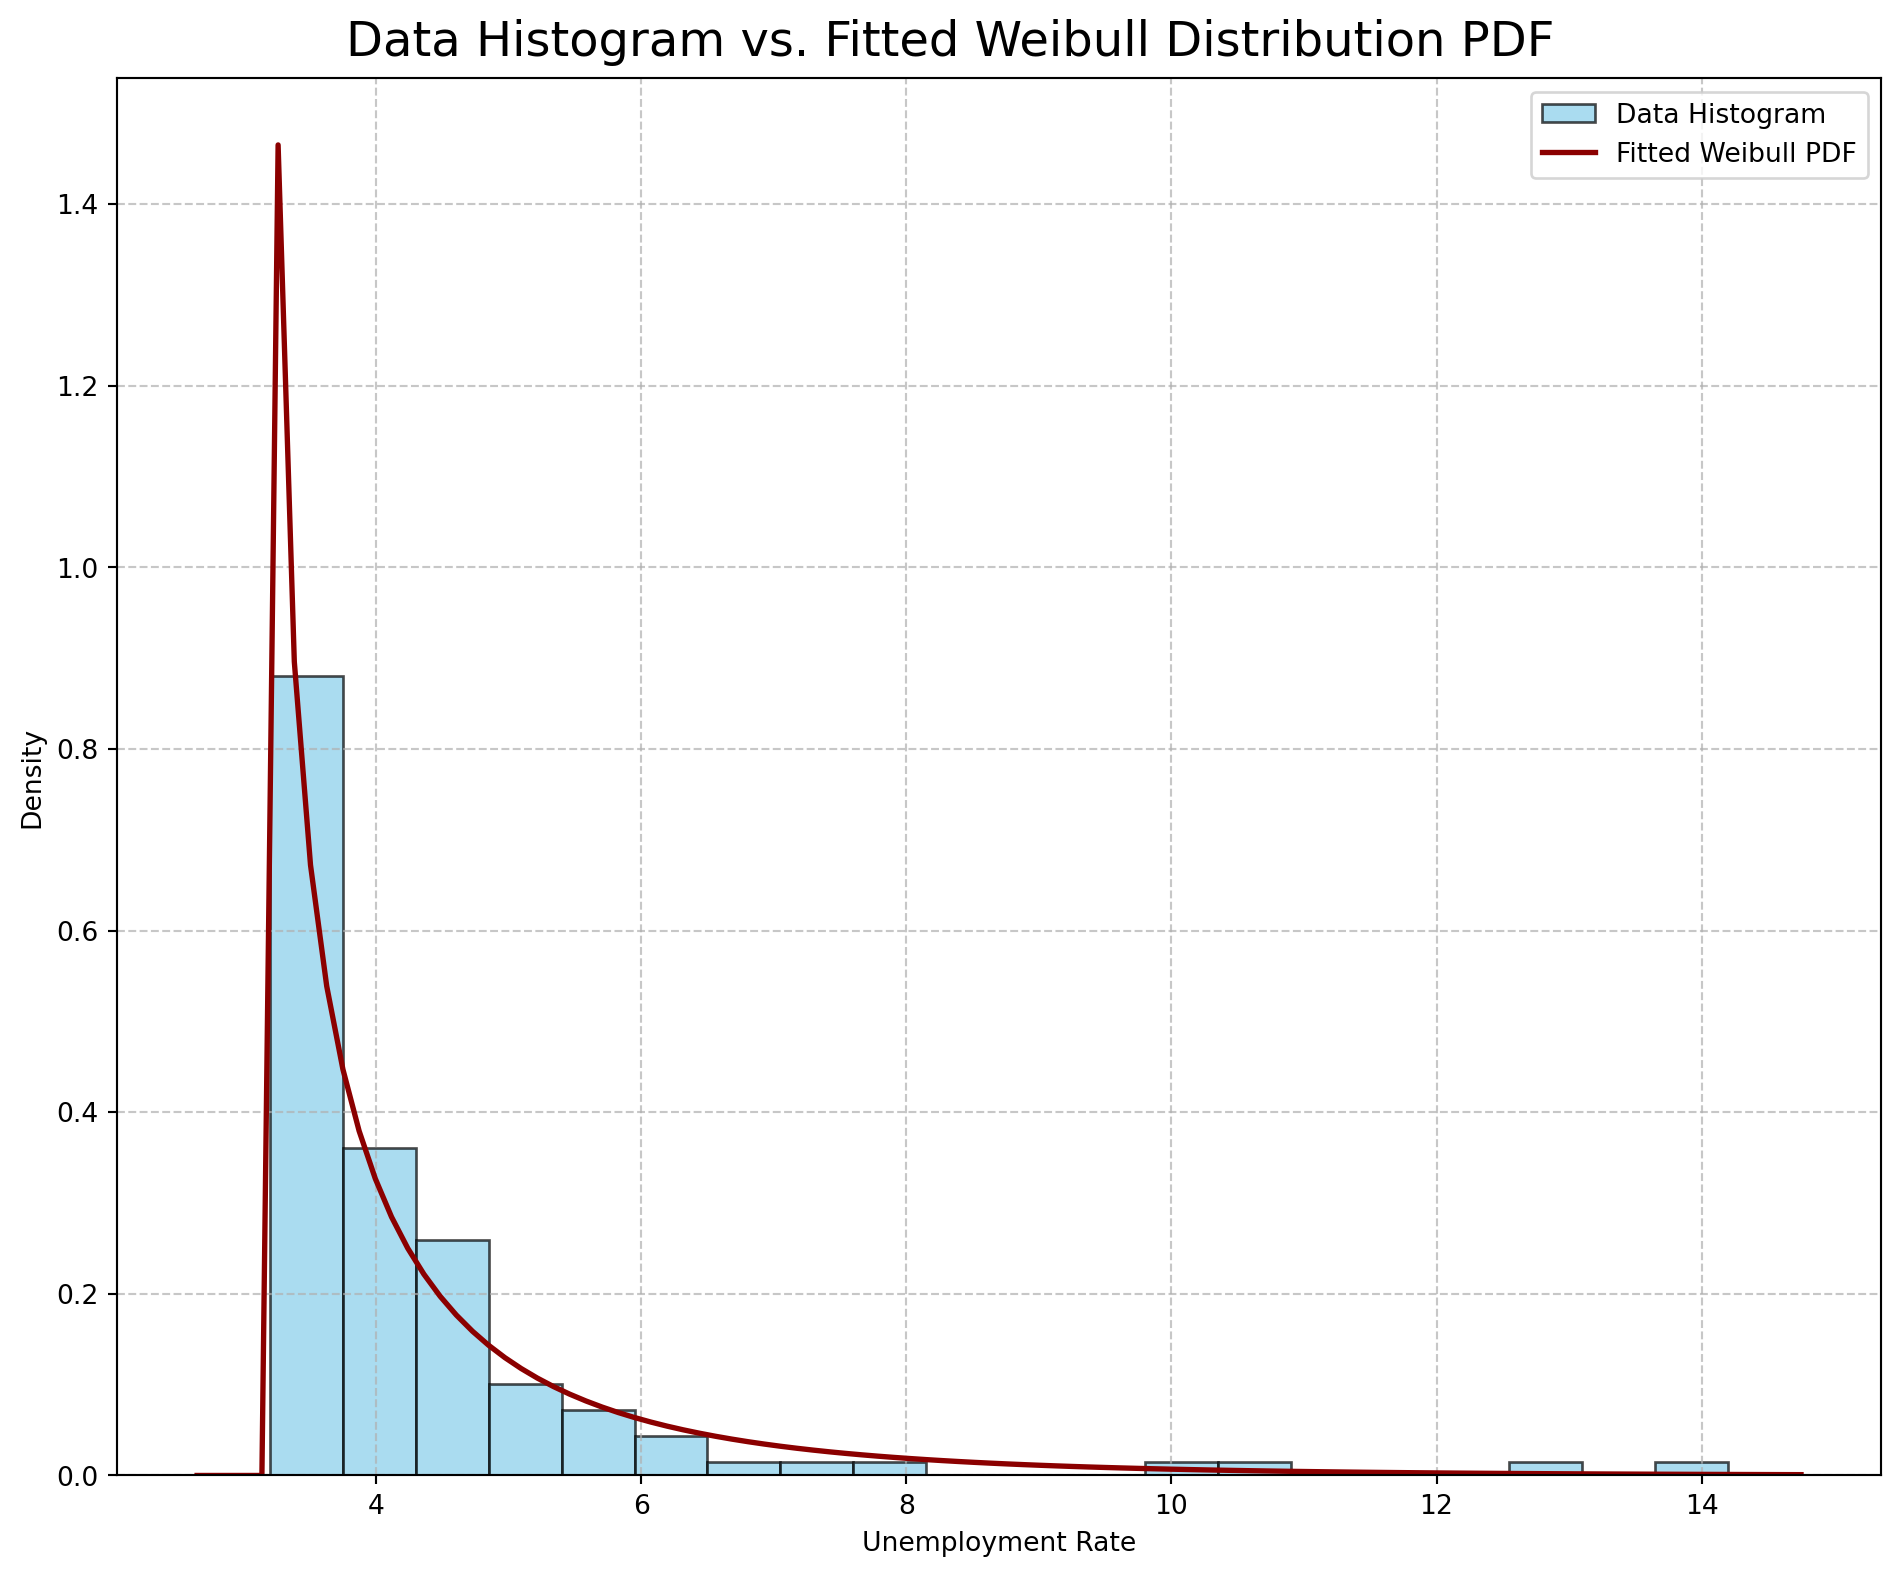

In [14]:
#| label: fig-histogram-weibull
#| fig-cap: Unmployment Rate Histogram vs. Fitted Weibull PDF
#| fig-alt: Plot the histogram of unemployment rate data and overlay the Probability Density Function (PDF) of the fitted Weibull distribution.

# Fit Weibull distribution using MLE
from scipy.stats import weibull_min, skew, kstest
from scipy.special import gamma as gamma_func # For Weibull mean calculation
c_fit, loc_fit, scale_fit = weibull_min.fit(data_to_fit) # fit weibull distribution

# Print the estimated parameters
# print(f"\nFitted Weibull Distribution Parameters:")
# print(f"  Shape parameter 'c' (k): {c_fit:.4f}")
# print(f"  Location parameter (loc): {loc_fit:.4f}")
# print(f"  Scale parameter (scale, lambda): {scale_fit:.4f}")

# Visualize the fit
fig, ax = plt.subplots(1, 1, figsize = (10, 8))
## Histogram of the unemployment data
ax.hist(data_to_fit, bins = 20, density=True, color='skyblue', alpha= 0.7, edgecolor='black', label = 'Data Histogram')
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)

## Plot fitted gamma pdf
p = weibull_min.pdf(x, c_fit, loc=loc_fit, scale=scale_fit)
ax.plot(x, p, 'darkred', lw=2, label='Fitted Weibull PDF')
ax.set_xlabel('Unemployment Rate', fontsize=10)
ax.set_ylabel('Density', fontsize=10)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.suptitle("Data Histogram vs. Fitted Weibull Distribution PDF", y=1.02, fontsize=18)
plt.show()

In [15]:
# Fit the Weibull
d_statistic, p_value = kstest(data_to_fit, lambda x: weibull_min.cdf(x, c_fit, loc=loc_fit, scale=scale_fit))
# Calculate inferred mean
fitted_mean = loc_fit + scale_fit * gamma_func(1 + 1/c_fit)
# print(f"\nKolmogorov-Smirnov Test Results:")
# print(f"  D-statistic: {d_statistic:.4f}")
# print(f"  P-value: {p_value:.4f}")

In [16]:
#| label: tbl-weibull-params
#| tbl-cap: Weibull Distribution and Fitness Statistics

# Print out the Weibull stats
weibull_stats = {
  "Parameters": [
    "Shape (c)",
    "Location (loc)" ,
    "Scale",
    "D_statistics",
    "P-value",
    "Fitted Mean"
  ],
  "Values": [
     round(c_fit, 4),
     round(loc_fit, 4),
     round(scale_fit, 4),
     round(d_statistic, 4),
     round(p_value, 4),
     round(fitted_mean, 2)
  ]
}
weibull_stats_table = pd.DataFrame(weibull_stats)
display(weibull_stats_table.style.hide(axis="index"))

Parameters,Values
Shape (c),0.709300
Location (loc),3.200000
Scale,0.920400
D_statistics,0.104700
P-value,0.117300
Fitted Mean,4.350000


The overlayed smooth PDF curve on top of original data's histogram @fig-histogram-weibull suggests that the Weibull distribution matches the distribution of the actual data. The results of the Weibull distribution, summarized in Table @tbl-weibull-params, including the shape, location, and scale parameters, along with the D-statistic, P-value, and fitted mean also proves Weibull distribution is a good fit, supported by a KS test p-value of 0.1173 (greater than 0.05). The estimated parameters (c=0.7093, loc=3.2000, scale=0.9204) align well with the spread of the data. Shape (c<1): Confirms the strong right-skewness of the data. Location (loc=3.2000): Indicates the distribution starts around 3.20, matching data's lower bound. Inferred Mean: The calculated mean of approximately 4.35 from these parameters is close but slightly higher than the data's actual mean of around 4, showing a good capture of central tendency.

### Race model - Define the prior means for overall population
```python
### population unemployment mean probability from the fitted Weibull distribution
weibull_fitted_mean_prob = 0.0435
# Convert the fitted mean probability to its log-odds equivalent in order to model binary outcome with logistic regression
population_mean_log_odds = np.log(weibull_fitted_mean_prob / (1 - weibull_fitted_mean_prob))
print(f"population mean log-odds: {population_mean_log_odds:.4f}")
```

In [17]:
# Population unemployment mean probability from the fitted Weibull distribution
weibull_fitted_mean_prob = 0.0435
# Convert the fitted mean probability to its log-odds equivalent in order to model binary outcome with logistic regression
population_mean_log_odds = np.log(weibull_fitted_mean_prob / (1 - weibull_fitted_mean_prob))
print(f"population mean log-odds: {population_mean_log_odds:.4f}")

population mean log-odds: -3.0905


### Race model - Define the prior means by races
```python
# Function to find the means of different demographics
def mean_prob_demographic(df_name, demographic_type, demographic_description):
    demographic_mean_prob = df_dic[df_name].loc[df_dic[df_name][demographic_type]==demographic_description]['Unemployment_rate'].mean()/100
    demographic_mean_log_odds = np.log(demographic_mean_prob / (1 - demographic_mean_prob))
    # beta_effect is the difference between the demographic group mean log-odds and the population mean log-odds
    beta_effect = demographic_mean_log_odds - population_mean_log_odds
    return beta_effect

# Create a grid of demographic information to return the means
demographic_grid = pd.DataFrame({
    "df_name":[
        'Race',
        'Race',
        'Race'
    ],
    "demographic_type":[
        "Race", 
        "Race",
        "Race"
    ],
    "demographic_description":[
        'black_and_african',
        'white',
        'asian'
    ]
})
# Return the beta_effect of different demographics
demographic_grid['beta_effect']= np.float64(0)
for row in range(0,len(demographic_grid)):
    # Mean of demographic groups
    beta_effect = mean_prob_demographic(demographic_grid['df_name'][row], demographic_grid['demographic_type'][row], demographic_grid['demographic_description'][row])
    demographic_grid['beta_effect'][row] = beta_effect

display(demographic_grid)
```

In [18]:
# Function to find the means of different demographics
def mean_prob_demographic(df_name, demographic_type, demographic_description):
    demographic_mean_prob = df_dic[df_name].loc[df_dic[df_name][demographic_type]==demographic_description]['Unemployment_rate'].mean()/100
    demographic_mean_log_odds = np.log(demographic_mean_prob / (1 - demographic_mean_prob))
    # beta_effect is the difference between the demographic group mean log-odds and the population mean log-odds
    beta_effect = demographic_mean_log_odds - population_mean_log_odds
    return beta_effect

# Create a grid of demographic information to return the means
demographic_grid = pd.DataFrame({
    "df_name":[
        'Race',
        'Race',
        'Race'
    ],
    "demographic_type":[
        "Race", 
        "Race",
        "Race"
    ],
    "demographic_description":[
        'black_and_african',
        'white',
        'asian'
    ]
})
# Return the beta_effect of different demographics
demographic_grid['beta_effect']= np.float64(0)
for row in range(0,len(demographic_grid)):
    # Mean of demographic groups
    beta_effect = mean_prob_demographic(demographic_grid['df_name'][row], demographic_grid['demographic_type'][row], demographic_grid['demographic_description'][row])
    demographic_grid['beta_effect'][row] = beta_effect

display(demographic_grid)

,df_name,demographic_type,demographic_description,beta_effect
0,Race,Race,black_and_african,0.579129
1,Race,Race,white,-0.051353
2,Race,Race,asian,-0.105245


The corresponding beta_effect for each of three races are shown in table above. These beta parameters are additive race effect parameter on population mean.

### Race model - Train-test split
Before PyMC - Split survey data to train and test datasets in order to test the performance of the models

```python
from sklearn.model_selection import train_test_split
train_df_survey, test_df_survey = train_test_split(df_survey_jun_jul, test_size=0.2, random_state=42)
```

In [19]:
from sklearn.model_selection import train_test_split
train_df_survey, test_df_survey = train_test_split(df_survey_jun_jul, test_size=0.2, random_state=5650)

### Race model - Define the PyMC model
This section sets up the Bayesian model to estimate the additive race effect relative to the fixed baseline.

```python
# Create the pymc model
import pymc as pm
import arviz as az

X_train = train_df_survey[['is_black_african','is_asian', 'is_white']]
y_train = train_df_survey['unemployment_status']

X_test = test_df_survey[['is_black_african','is_asian', 'is_white']]
y_test = test_df_survey['unemployment_status']

train_coords = {
    'response_id': X_train.index.values
}

with pm.Model(coords=train_coords) as unemployment_race_model:
    # Prior of population mean log odds
    mu_population_log_odds = pm.Normal('mu_population_log_odds', mu=population_mean_log_odds, sigma=0.5)
        
    # Additive race effect parameter on population mean
    beta_black = pm.Normal('beta_black', mu=demographic_grid[demographic_grid['demographic_description']=='black_and_african']['beta_effect'], sigma=0.3) # Can be positive or negative

    beta_asian = pm.Normal('beta_asian', mu=demographic_grid[demographic_grid['demographic_description']=='asian']['beta_effect'], sigma=0.3) 

    beta_white = pm.Normal('beta_white', mu=demographic_grid[demographic_grid['demographic_description']=='white']['beta_effect'], sigma=0.3) 

    black_obs = pm.Data("black_obs", X_train['is_black_african'], dims="response_id")
    white_obs = pm.Data("white_obs", X_train['is_white'], dims="response_id")
    asian_obs = pm.Data("asian_obs", X_train['is_asian'], dims="response_id")

    p_unemployment = pm.Deterministic("p_unemployment", pm.math.invlogit(mu_population_log_odds + beta_black * black_obs + beta_white * white_obs + beta_asian * asian_obs), dims = 'response_id')

    unemployment_obs = pm.Data("unemployment_obs", y_train, dims="response_id")

    unemployment = pm.Bernoulli("unemployment", p = p_unemployment, observed=unemployment_obs, dims="response_id")
```

In [20]:
# Create the pymc model
import pymc as pm
import arviz as az

X_train = train_df_survey[['is_black_african','is_asian', 'is_white']]
y_train = train_df_survey['unemployment_status']

X_test = test_df_survey[['is_black_african','is_asian', 'is_white']]
y_test = test_df_survey['unemployment_status']

train_coords = {
    'response_id': X_train.index.values
}

with pm.Model(coords=train_coords) as unemployment_race_model:
    # Prior of population mean log odds
    mu_population_log_odds = pm.Normal('mu_population_log_odds', mu=population_mean_log_odds, sigma=0.5)
        
    # Additive race effect parameter on population mean
    beta_black = pm.Normal('beta_black', mu=demographic_grid[demographic_grid['demographic_description']=='black_and_african']['beta_effect'], sigma=0.3) # Can be positive or negative

    beta_asian = pm.Normal('beta_asian', mu=demographic_grid[demographic_grid['demographic_description']=='asian']['beta_effect'], sigma=0.3) 

    beta_white = pm.Normal('beta_white', mu=demographic_grid[demographic_grid['demographic_description']=='white']['beta_effect'], sigma=0.3) 

    black_obs = pm.Data("black_obs", X_train['is_black_african'], dims="response_id")
    white_obs = pm.Data("white_obs", X_train['is_white'], dims="response_id")
    asian_obs = pm.Data("asian_obs", X_train['is_asian'], dims="response_id")

    p_unemployment = pm.Deterministic("p_unemployment", pm.math.invlogit(mu_population_log_odds + beta_black * black_obs + beta_white * white_obs + beta_asian * asian_obs), dims = 'response_id')

    unemployment_obs = pm.Data("unemployment_obs", y_train, dims="response_id")

    unemployment = pm.Bernoulli("unemployment", p = p_unemployment, observed=unemployment_obs, dims="response_id")

### Race model - Graph PGM
```python
pm.model_to_graphviz(unemployment_race_model)
```

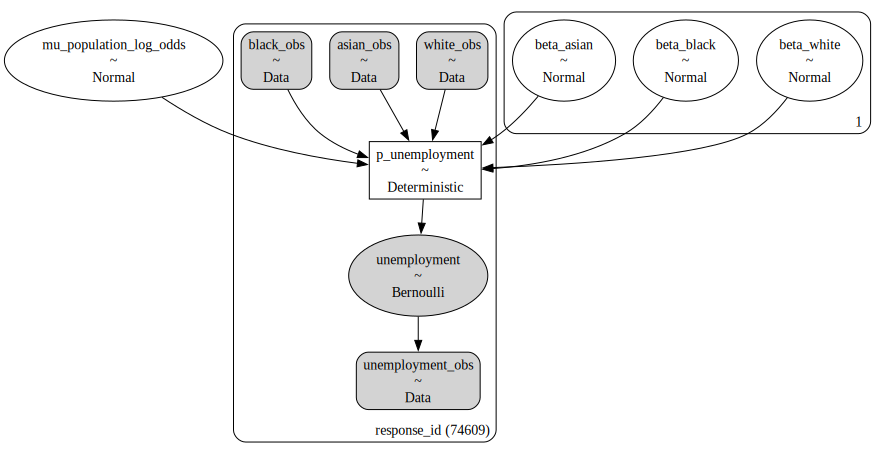

In [21]:
pm.model_to_graphviz(unemployment_race_model)

### Race model - Estimate model parameters
```python
print("Starting Race Model Sampling...")
with unemployment_race_model:
    race_idata = pm.sample(tune =500, draw = 500, random_seed=5650)
```

In [22]:
print("Starting Race Model Sampling...")
with unemployment_race_model:
    race_idata = pm.sample(tune =500, draw = 500, random_seed=5650)

Starting Race Model Sampling...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mu_population_log_odds, beta_black, beta_asian, beta_white]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 36 seconds.


### Race model - Extract Posterior Predictive Distribution on Test data

```python
# Update to test data
test_coords = {
    'response_id': X_test.index.values
}
with unemployment_race_model:
    pm.set_data({"unemployment_obs": y_test,
                 "black_obs": X_test['is_black_african'],
                 "white_obs": X_test['is_white'],
                 "asian_obs": X_test['is_asian']}, coords=test_coords)
with unemployment_race_model:
    race_idata = pm.sample_posterior_predictive(race_idata, random_seed=5650)

```

In [23]:
# Update to test data
test_coords = {
    'response_id': X_test.index.values
}
with unemployment_race_model:
    pm.set_data({"unemployment_obs": y_test,
                 "black_obs": X_test['is_black_african'],
                 "white_obs": X_test['is_white'],
                 "asian_obs": X_test['is_asian']}, coords=test_coords)
with unemployment_race_model:
    race_test_idata = pm.sample_posterior_predictive(race_idata, random_seed=5650)

Sampling: [unemployment]


Output()

```python
# Extract means of unemployment values from the posterior predictive distribution given test data
race_test_meanunemployment = race_test_idata.posterior_predictive['unemployment'].mean(dim=['chain','draw'])
print(race_test_meanunemployment.values)
```

In [24]:
# Extract means of unemployment values from the posterior predictive distribution given test data
race_test_meanunemployment = race_test_idata.posterior_predictive['unemployment'].mean(dim=['chain','draw'])
print(race_test_meanunemployment.values)

[0.0365  0.03225 0.03225 ... 0.0275  0.036   0.027  ]


### Race model - Plot predictive vs. unemployment rate in the test data
```python
black_obs = race_test_idata.constant_data['black_obs'].values
white_obs = race_test_idata.constant_data['white_obs'].values  
asian_obs = race_test_idata.constant_data['asian_obs'].values

race_list = [
    'black' if b == 1 else
    'white' if w == 1 else
    'asian' if a == 1 else None
    for b, w, a in zip(black_obs, white_obs, asian_obs)
]

rate_df = pd.DataFrame({
    'race_list': race_list, 
    'y_predict': race_test_idata.posterior_predictive['unemployment'].mean(dim=['chain','draw']).values, 
    'y_true': race_test_idata.observed_data['unemployment'].values
    })
race_rate_df = rate_df.groupby('race_list')[['y_predict','y_true']].mean().reset_index()
race_rate_df_long = race_rate_df.melt(id_vars="race_list", var_name="y_label", value_name="unemployment_rate_mean")

# Bar plot
import matplotlib.pyplot as plt
import seaborn as sns

# Create the bar plot
fig, ax = plt.subplots(figsize=(6, 3))
sns.barplot(
    x="race_list", y='unemployment_rate_mean', hue='y_label', data=race_rate_df_long,
    alpha=0.9, ax=ax,
    palette={"y_predict": "skyblue", "y_true": "blue"}
)
ax.set_title("Rates of 'Predictive Unemployment' mean vs. 'True Unemployment' mean")
plt.tight_layout()
plt.show()
```

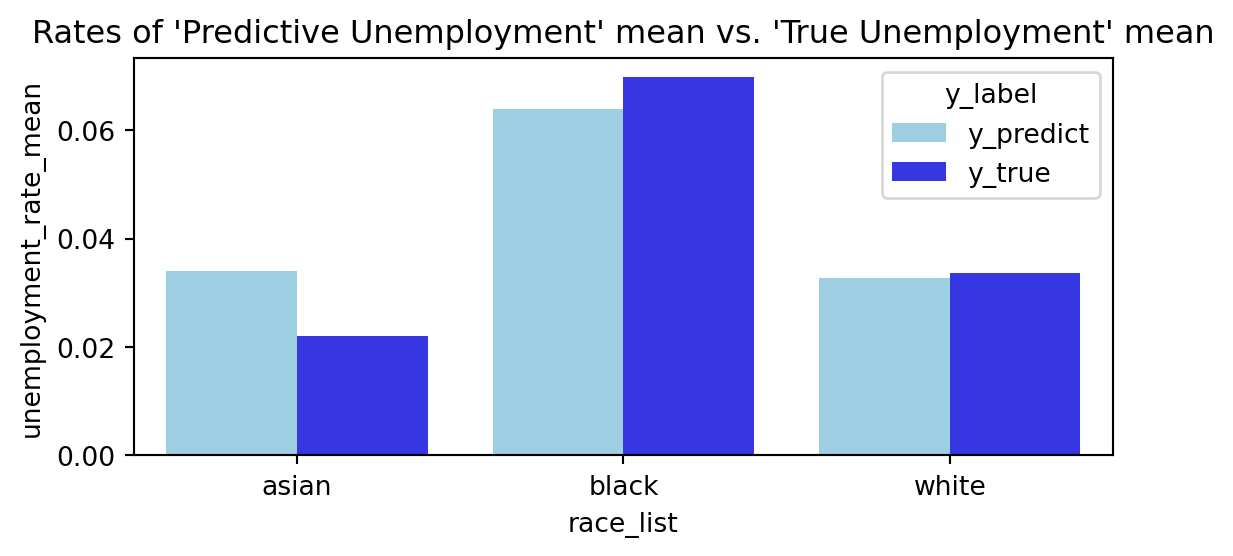

In [25]:
#| label: fig-bar-race-model
#| fig-cap: Bar Plot - Predictive Unemployment Rate vs. True Rate By Races
#| fig-alt: Plot the unemployment rate means predicted by race PGM model and the survey results

black_obs = race_test_idata.constant_data['black_obs'].values
white_obs = race_test_idata.constant_data['white_obs'].values  
asian_obs = race_test_idata.constant_data['asian_obs'].values

race_list = [
    'black' if b == 1 else
    'white' if w == 1 else
    'asian' if a == 1 else None
    for b, w, a in zip(black_obs, white_obs, asian_obs)
]

rate_df = pd.DataFrame({
    'race_list': race_list, 
    'y_predict': race_test_idata.posterior_predictive['unemployment'].mean(dim=['chain','draw']).values, 
    'y_true': race_test_idata.observed_data['unemployment'].values
    })
race_rate_df = rate_df.groupby('race_list')[['y_predict','y_true']].mean().reset_index()
race_rate_df_long = race_rate_df.melt(id_vars="race_list", var_name="y_label", value_name="unemployment_rate_mean")

# Bar plot
import matplotlib.pyplot as plt
import seaborn as sns

# Create the bar plot
fig, ax = plt.subplots(figsize=(6, 3))
sns.barplot(
    x="race_list", y='unemployment_rate_mean', hue='y_label', data=race_rate_df_long,
    alpha=0.9, ax=ax,
    palette={"y_predict": "skyblue", "y_true": "blue"}
)
ax.set_title("Rates of 'Predictive Unemployment' mean vs. 'True Unemployment' mean")
plt.tight_layout()
plt.show()

The bar plot above (@fig-bar-race-model) demonstrates that the PGM race model predicts unemployment rates well. It accurately captures the highest unemployment rate for the Black race, closely matching the survey data. However, the model tends to overestimate the unemployment rate for the Asian group compared to the observed values.


### Industry model - Define priors

```python
## 1. Exclude some industries and persons "not in labor force" and industries that don't have historical unemployment stats
survey_df_industry = survey_df[~survey_df['industry_name'].isin(['Construction',
                              'Mining',
                              'Other services',
                              'Agriculture, forestry, fishing, and hunting',
                              'Armed Forces'])]
survey_df_industry = survey_df_industry[survey_df_industry['employment_status_description']!="not in labor force"]
## Factorize the industry_name column to get numerical indices and names
industry_idx, industry_names = survey_df_industry['industry_name'].factorize()
survey_df_industry['industry_idx'] = industry_idx
## Map EmploymentStatus to numerical (0 for Employed, 1 for Unemployed)
survey_df_industry['unemployment_status'] = survey_df_industry['employment_status_description'].map({'employed': 0, 'unemployed': 1})

## 2. Get the prior means and sds of unemployment rates by industries from the historical monthly statistics (exlcuding 2020-2021)
df_industry_monthly_ur = df_industry[~df_industry['Industry'].isin(['construction',
                              'mining_quarrying_and_oil_and_gas_ extraction',
                              'other_services',
                              'agricultural',
                              'self_employed',
                              'non_durable_goods',
                              'durable_goods'])]

ur_by_industry = pd.DataFrame(df_industry_monthly_ur.groupby('Industry', as_index=False).agg(
    mean_ur = ('Unemployment_rate','mean'),
    sd_ur = ('Unemployment_rate', 'std')
))
 # modify the industry name column to align with industry_names
ur_by_industry['Industry']=['Educational and health services',
                            'Financial activities',
                            'Public administration',
                            'Information',
                            'Leisure and hospitality',
                            'Manufacturing',
                            'Professional and business services',
                            'Transportation and utilities',
                            'Wholesale and retail trade']
# Logit transformation function
def logit(p):
    return np.log(p / (1 - p))
ur_by_industry['mean_ur_logit'] = logit(ur_by_industry['mean_ur']/100)
ur_by_industry['sd_ur_logit'] = logit(ur_by_industry['sd_ur']/100)

# priors
ur_by_industry_copy = ur_by_industry.copy()
ur_by_industry_copy = ur_by_industry_copy.set_index('Industry')
prior_mu_alpha_vals = np.array([ur_by_industry_copy.loc[ind, 'mean_ur_logit'] for ind in industry_names])
prior_sigma_alpha_vals = np.array([ur_by_industry_copy.loc[ind, 'sd_ur_logit'] for ind in industry_names])

```

In [26]:
## 1. Exclude some industries and persons "not in labor force" and industries that don't have historical unemployment stats
survey_df_industry = survey_df[~survey_df['industry_name'].isin(['Construction',
                              'Mining',
                              'Other services',
                              'Agriculture, forestry, fishing, and hunting',
                              'Armed Forces'])]
survey_df_industry = survey_df_industry[survey_df_industry['employment_status_description']!="not in labor force"]
## Factorize the industry_name column to get numerical indices and names
industry_idx, industry_names = survey_df_industry['industry_name'].factorize()
survey_df_industry['industry_idx'] = industry_idx
## Map EmploymentStatus to numerical (0 for Employed, 1 for Unemployed)
survey_df_industry['unemployment_status'] = survey_df_industry['employment_status_description'].map({'employed': 0, 'unemployed': 1})

## 2. Get the prior means and sds of unemployment rates by industries from the historical monthly statistics (exlcuding 2020-2021)
df_industry_monthly_ur = df_industry[~df_industry['Industry'].isin(['construction',
                              'mining_quarrying_and_oil_and_gas_ extraction',
                              'other_services',
                              'agricultural',
                              'self_employed',
                              'non_durable_goods',
                              'durable_goods'])]

ur_by_industry = pd.DataFrame(df_industry_monthly_ur.groupby('Industry', as_index=False).agg(
    mean_ur = ('Unemployment_rate','mean'),
    sd_ur = ('Unemployment_rate', 'std')
))
 # modify the industry name column to align with industry_names
ur_by_industry['Industry']=['Educational and health services',
                            'Financial activities',
                            'Public administration',
                            'Information',
                            'Leisure and hospitality',
                            'Manufacturing',
                            'Professional and business services',
                            'Transportation and utilities',
                            'Wholesale and retail trade']
# Logit transformation function
def logit(p):
    return np.log(p / (1 - p))
ur_by_industry['mean_ur_logit'] = logit(ur_by_industry['mean_ur']/100)
ur_by_industry['sd_ur_logit'] = logit(ur_by_industry['sd_ur']/100)

# priors
ur_by_industry_copy = ur_by_industry.copy()
ur_by_industry_copy = ur_by_industry_copy.set_index('Industry')
prior_mu_alpha_vals = np.array([ur_by_industry_copy.loc[ind, 'mean_ur_logit'] for ind in industry_names])
prior_sigma_alpha_vals = np.array([ur_by_industry_copy.loc[ind, 'sd_ur_logit'] for ind in industry_names])

### Industry model - Train-test split
```python
from sklearn.model_selection import train_test_split
train_df_industry_survey, test_df_industry_survey = train_test_split(survey_df_industry, test_size=0.2, random_state=42)
```

In [27]:
train_df_industry_survey, test_df_industry_survey = train_test_split(survey_df_industry, test_size=0.2, random_state=5650)

X_train_ind = train_df_industry_survey[['industry_name','industry_idx']]
y_train_ind = train_df_industry_survey['unemployment_status']

X_test_ind = test_df_industry_survey[['industry_name','industry_idx']]
y_test_ind = test_df_industry_survey['unemployment_status']

### Industry model - Define the Adaptive pooling PyMC model
```python
# Define the PGM model with train data
coords = {"industry": industry_names}
with pm.Model(coords=coords) as unemployment_industry_model:
    industry_idx_obs = pm.Data("industry_idx_obs", X_train_ind['industry_idx'], dims="obs_id")
    # Global Priors 
    sigma = pm.Exponential("sigma", 1) # standard deviation for alpha_industry
    # Industry-Specific Parameters - observed industry means
    mu_alpha_industry = pm.Data("mu_alpha_industry", prior_mu_alpha_vals, dims="industry") # history industry means
    alpha_industry = pm.Normal("alpha_industry", 
                                mu=mu_alpha_industry, # historical industry means distribution
                                sigma=sigma,
                                dims="industry")
    # Probability of unemployment of each industry determined by alpha_industry
    p_unemployment = pm.Deterministic("p_unemployment", pm.math.invlogit(alpha_industry[industry_idx_obs]), dims='obs_id')
    unemployment_obs = pm.Data("unemployment_obs", y_train_ind, dims="obs_id")
    # Observed data - unemployment status
    unemployment = pm.Bernoulli("unemployment", p=p_unemployment, observed=unemployment_obs, dims="obs_id")
```

In [28]:
# Define the PGM model with train data
coords = {"industry": industry_names}
with pm.Model(coords=coords) as unemployment_industry_model:
    industry_idx_obs = pm.Data("industry_idx_obs", X_train_ind['industry_idx'], dims="obs_id")
    # Global Priors 
    sigma = pm.Exponential("sigma", 1) # standard deviation for alpha_industry
    # Industry-Specific Parameters - observed industry means
    mu_alpha_industry = pm.Data("mu_alpha_industry", prior_mu_alpha_vals, dims="industry") # history industry means
    alpha_industry = pm.Normal("alpha_industry", 
                                mu=mu_alpha_industry, # historical industry means distribution
                                sigma=sigma,
                                dims="industry")
    # Probability of unemployment of each industry determined by alpha_industry
    p_unemployment = pm.Deterministic("p_unemployment", pm.math.invlogit(alpha_industry[industry_idx_obs]), dims='obs_id')
    unemployment_obs = pm.Data("unemployment_obs", y_train_ind, dims="obs_id")
    # Observed data - unemployment status
    unemployment = pm.Bernoulli("unemployment", p=p_unemployment, observed=unemployment_obs, dims="obs_id")

### Industry model - Visualize PGM

```python
## 4.Visualize the PGM
pm.model_to_graphviz(unemployment_industry_model)  
```

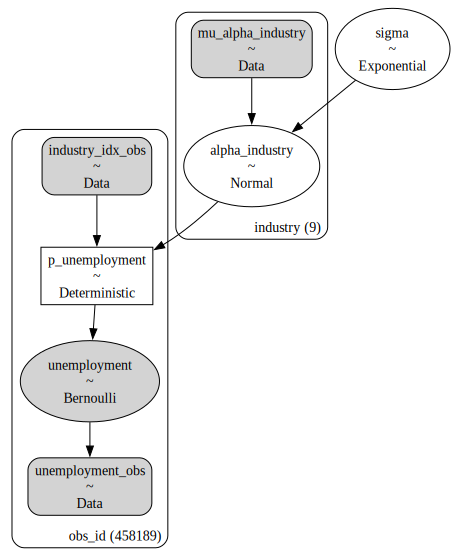

In [29]:
## 4.Visualize the PGM
display(pm.model_to_graphviz(unemployment_industry_model))

### Industry model - Estimate model parameters
```python
print("Starting Industry Model Sampling...")
with unemployment_industry_model:
    industry_idata = pm.sample(tune = 500, draws=500, random_seed=5650) # reduce the draws due to the size of the data
```

In [30]:
print("Starting Industry Model Sampling...")
with unemployment_industry_model:
    industry_idata = pm.sample(tune = 500, draws=500, random_seed=5650) # reduce the draws due to the size of the data

Initializing NUTS using jitter+adapt_diag...


Starting Industry Model Sampling...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [sigma, alpha_industry]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 108 seconds.


```python
# Posterior mean
industry_idata_post_mean = industry_idata.posterior.mean(dim=("chain", "draw"))
industry_idata_post_mean_iter = industry_idata_post_mean.sortby("alpha_industry")
industry_idata_post_mean_iter['alpha_prob'] = 1 / (1 + np.exp(-industry_idata_post_mean_iter['alpha_industry']))
industry_idata_post_mean.to_dataframe()
industry_idata_post_mean_hdi = az.hdi(industry_idata)
industry_idata_post_mean_hdi_iter = industry_idata_post_mean_hdi.sortby(industry_idata_post_mean_iter.alpha_industry)
industry_idata_post_mean_hdi_iter['alpha_prob']=1 / (1 + np.exp(-industry_idata_post_mean_hdi_iter['alpha_industry']))
industry_idata_post_mean_hdi_iter.to_dataframe()

# Plot the posterior alpha_industry (mean of unemployment)
fig, ax = plt.subplots(figsize=(10, 8))
industry_idata_post_mean_iter.plot.scatter(x='industry', y="alpha_prob", ax=ax, alpha=0.8, s=80)
ax.vlines(
    np.arange(industry_names.size),
    industry_idata_post_mean_hdi_iter.alpha_prob.sel(hdi="lower"),
    industry_idata_post_mean_hdi_iter.alpha_prob.sel(hdi="higher"),
    color="orange",
    alpha=0.6,
    linewidth=3
)
ax.grid(True, linestyle='--', alpha=0.6, color='lightgray')     
ax.tick_params(axis='x', labelsize=10, rotation=90)
ax.set_xlabel('Industry', fontsize = 12)
ax.set_ylabel('Posterior means', fontsize = 12)
ax.set_title("Estimated Industry-Specific Unemployment Rate (Adaptive Pooling)", y=1.02, fontsize=16)
plt.tight_layout() 
plt.show()
```

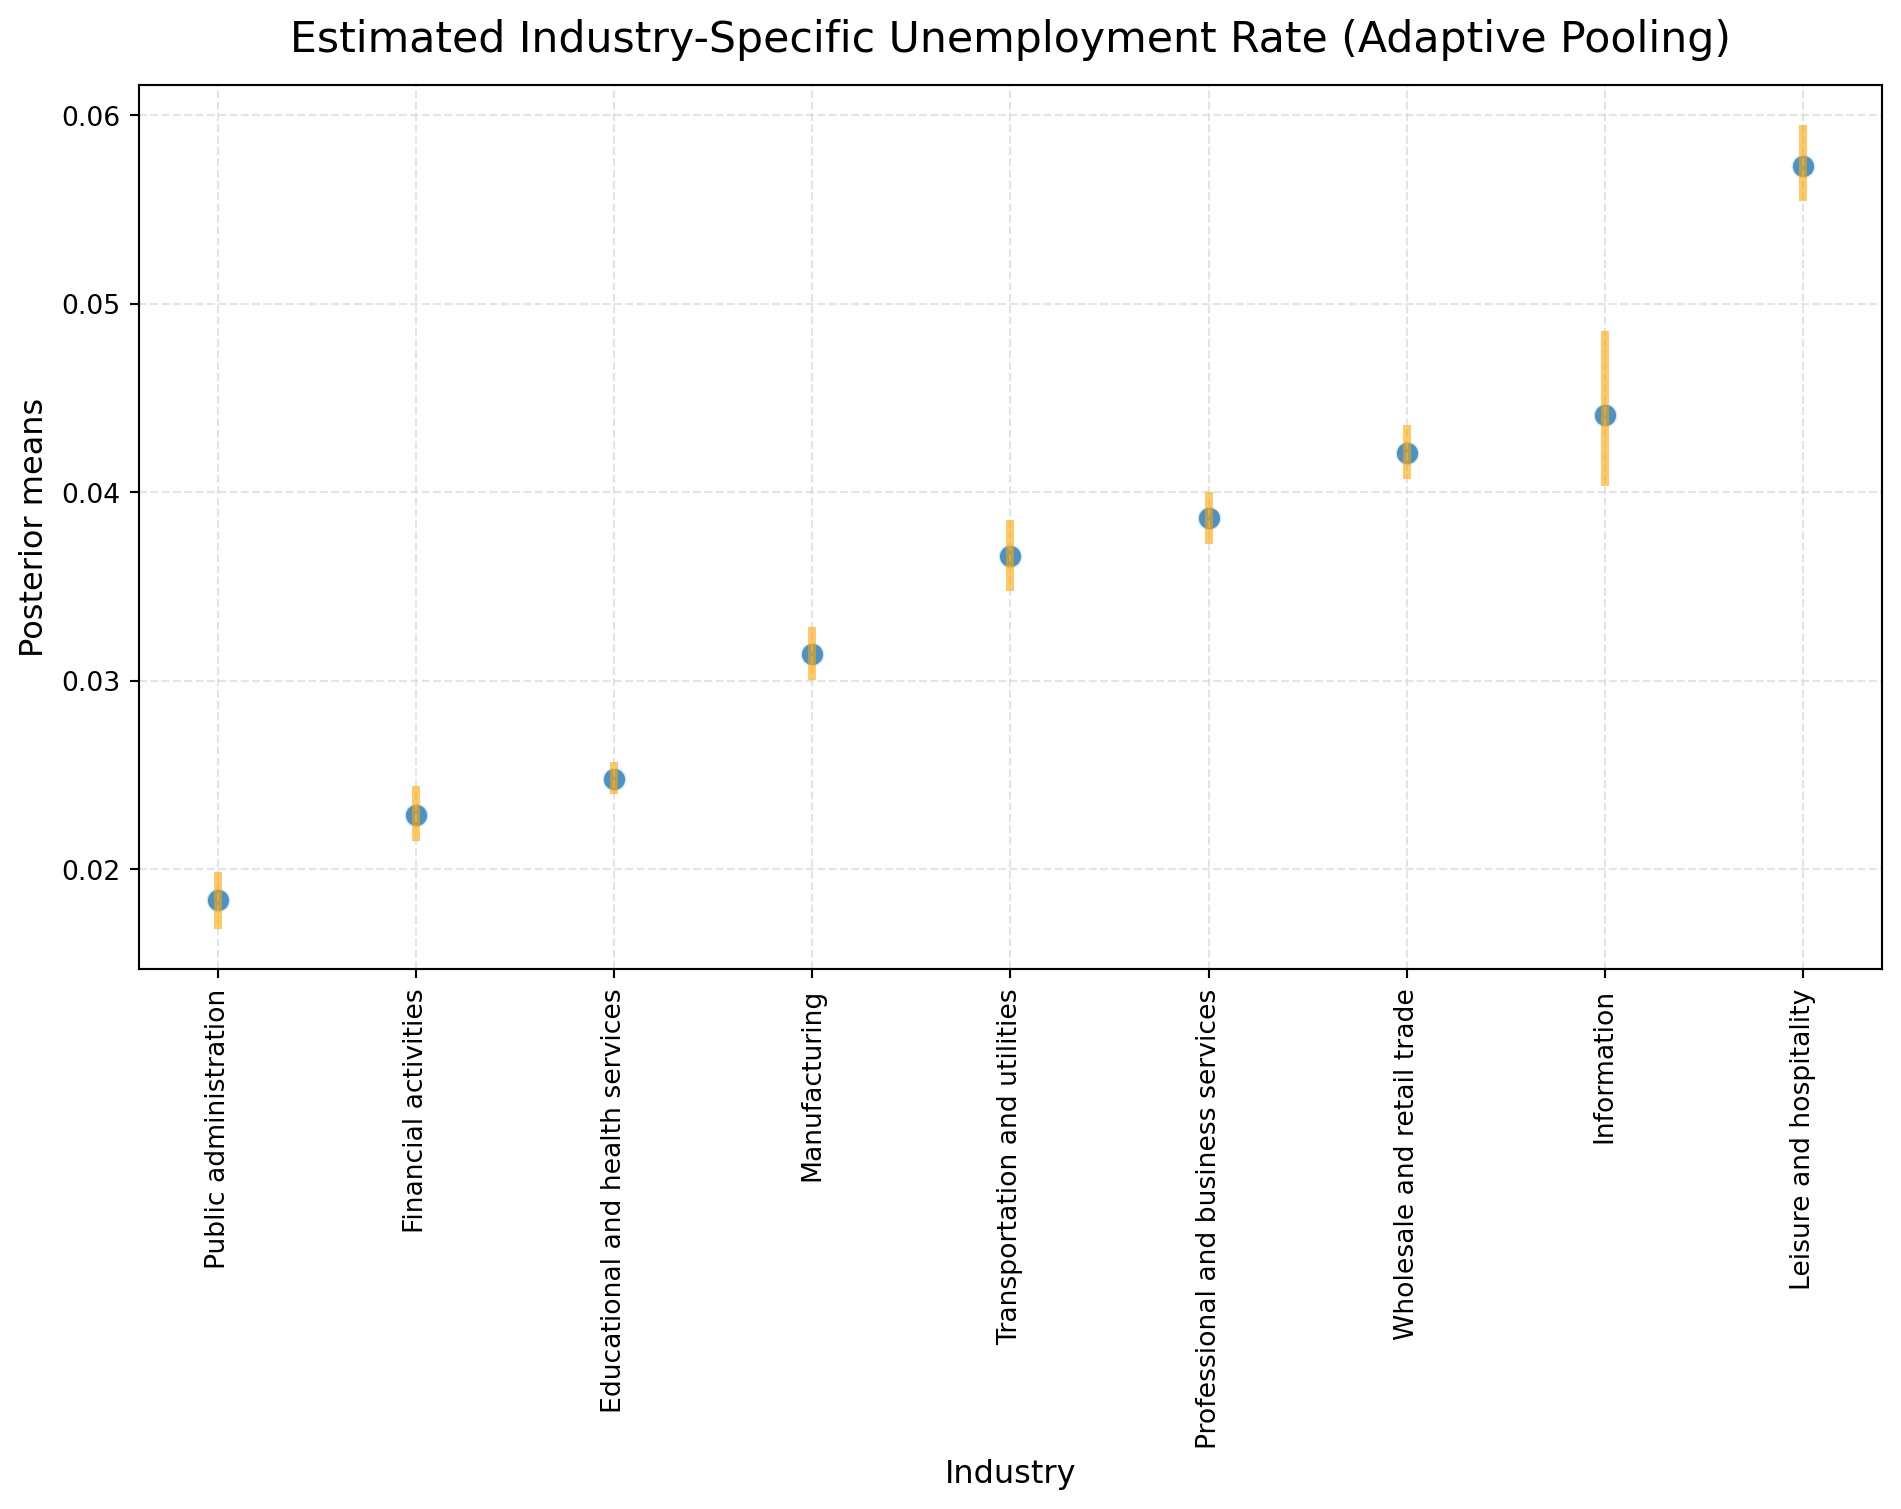

In [31]:
#| label: fig-industry-pgm-scatter
#| fig-cap: Estimated Industry-Specific Unemployment Rate (Adaptive Pooliing)
#| fig-alt: Plot the scatter plot of the estimated unemployment rates by industries

# Posterior mean
industry_idata_post_mean = industry_idata.posterior.mean(dim=("chain", "draw"))
industry_idata_post_mean_iter = industry_idata_post_mean.sortby("alpha_industry")
industry_idata_post_mean_iter['alpha_prob'] = 1 / (1 + np.exp(-industry_idata_post_mean_iter['alpha_industry']))
industry_idata_post_mean.to_dataframe()
industry_idata_post_mean_hdi = az.hdi(industry_idata)
industry_idata_post_mean_hdi_iter = industry_idata_post_mean_hdi.sortby(industry_idata_post_mean_iter.alpha_industry)
industry_idata_post_mean_hdi_iter['alpha_prob']=1 / (1 + np.exp(-industry_idata_post_mean_hdi_iter['alpha_industry']))
industry_idata_post_mean_hdi_iter.to_dataframe()

# Plot the posterior alpha_industry (mean of unemployment)
fig, ax = plt.subplots(figsize=(10, 8))
industry_idata_post_mean_iter.plot.scatter(x='industry', y="alpha_prob", ax=ax, alpha=0.8, s=80)
ax.vlines(
    np.arange(industry_names.size),
    industry_idata_post_mean_hdi_iter.alpha_prob.sel(hdi="lower"),
    industry_idata_post_mean_hdi_iter.alpha_prob.sel(hdi="higher"),
    color="orange",
    alpha=0.6,
    linewidth=3
)
ax.grid(True, linestyle='--', alpha=0.6, color='lightgray')     
ax.tick_params(axis='x', labelsize=10, rotation=90)
ax.set_xlabel('Industry', fontsize = 12)
ax.set_ylabel('Posterior means', fontsize = 12)
ax.set_title("Estimated Industry-Specific Unemployment Rate (Adaptive Pooling)", y=1.02, fontsize=16)
plt.tight_layout() 
plt.show()

### Industry model - Extract Posterior Predictive Distribution on Test data

```python
# Update to test data
with unemployment_industry_model:
    pm.set_data({"unemployment_obs": y_test_ind,
                 "industry_idx_obs": X_test_ind['industry_idx']})
with unemployment_industry_model:
    industry_test_idata = pm.sample_posterior_predictive(industry_idata, random_seed=5650)
```

In [32]:
# Update to test data
with unemployment_industry_model:
    pm.set_data({"unemployment_obs": y_test_ind,
                 "industry_idx_obs": X_test_ind['industry_idx']})
with unemployment_industry_model:
    industry_test_idata = pm.sample_posterior_predictive(industry_idata, random_seed=5650)

Sampling: [unemployment]


Output()

### Industry model - Extract Posterior Predictive Distribution on Test data

```python
# Update to test data
with unemployment_industry_model:
    pm.set_data({"unemployment_obs": y_test_ind,
                 "industry_idx_obs": X_test_ind['industry_idx']})
with unemployment_industry_model:
    industry_test_idata = pm.sample_posterior_predictive(industry_idata, random_seed=5650)
```

In [33]:
# Update to test data
with unemployment_industry_model:
    pm.set_data({"unemployment_obs": y_test_ind,
                 "industry_idx_obs": X_test_ind['industry_idx']})
with unemployment_industry_model:
    industry_test_idata = pm.sample_posterior_predictive(industry_idata, random_seed=5650)

Sampling: [unemployment]


Output()

### Industry model - Plot predictive vs. unemployment rate in the test data

```python
# Extract means of unemployment values from the posterior predictive distribution given test data
industry_test_meanunemployment = industry_test_idata.posterior_predictive['unemployment'].mean(dim=['chain','draw'])

# Add the predictive posterior means to the test dataframe
ind_rate_df = test_df_industry_survey[['industry_name','unemployment_status']]
ind_rate_df['unemployment_mean_pred'] = industry_test_meanunemployment
ind_rate_df = ind_rate_df.groupby('industry_name').agg(
    unemployment_mean_true = ('unemployment_status','mean'), unemployment_mean_pred = ('unemployment_mean_pred', 'mean')
)
```

In [34]:
#| label: tbl-industry-posterior_predict-means
#| tbl-cap: Predicted vs. True Unemployment Means By Industries

# Extract means of unemployment values from the posterior predictive distribution given test data
industry_test_meanunemployment = industry_test_idata.posterior_predictive['unemployment'].mean(dim=['chain','draw'])

# Add the predictive posterior means to the test dataframe
ind_rate_df = test_df_industry_survey[['industry_name','unemployment_status']]
ind_rate_df['unemployment_mean_pred'] = industry_test_meanunemployment
ind_rate_df = ind_rate_df.groupby('industry_name').agg(
    unemployment_mean_true = ('unemployment_status','mean'), unemployment_mean_pred = ('unemployment_mean_pred', 'mean')
).reset_index()

display(ind_rate_df)

,industry_name,unemployment_mean_true,unemployment_mean_pred
0,Educational and health services,0.024175,0.024808
1,Financial activities,0.023190,0.022936
2,Information,0.060263,0.044089
3,Leisure and hospitality,0.056349,0.057205
4,Manufacturing,0.031208,0.031418
5,Professional and business services,0.037860,0.038643
6,Public administration,0.017827,0.018390
7,Transportation and utilities,0.039534,0.036584
8,Wholesale and retail trade,0.041667,0.042109


@tbl-industry-posterior_predict-means displays the predicted vs. true unemployment rate means broken down by industries. Now we are going to visualize by scatter plot.

```python
# Scatter plot
x = np.arange(len(ind_rate_df))
fig, ax = plt.subplots(figsize = (10, 7))
ax.scatter(
    x,
    ind_rate_df['unemployment_mean_pred'],
    color = 'skyblue',
    label = 'Predicted Unemploymenet Rate'
)

ax.scatter(
    x,
    ind_rate_df['unemployment_mean_true'],
    color='blue',
    label = 'True Unemployment Rate'
)
ax.set_xticks(x)
ax.set_xticklabels(ind_rate_df['industry_name'],rotation=45, ha="right")

ax.set_ylabel("Mean Unemployment Rate")
ax.set_title("True vs Predicted Mean Unemployment by Industry", y = 1.02)
ax.legend()

plt.tight_layout()
#plt.show()
```

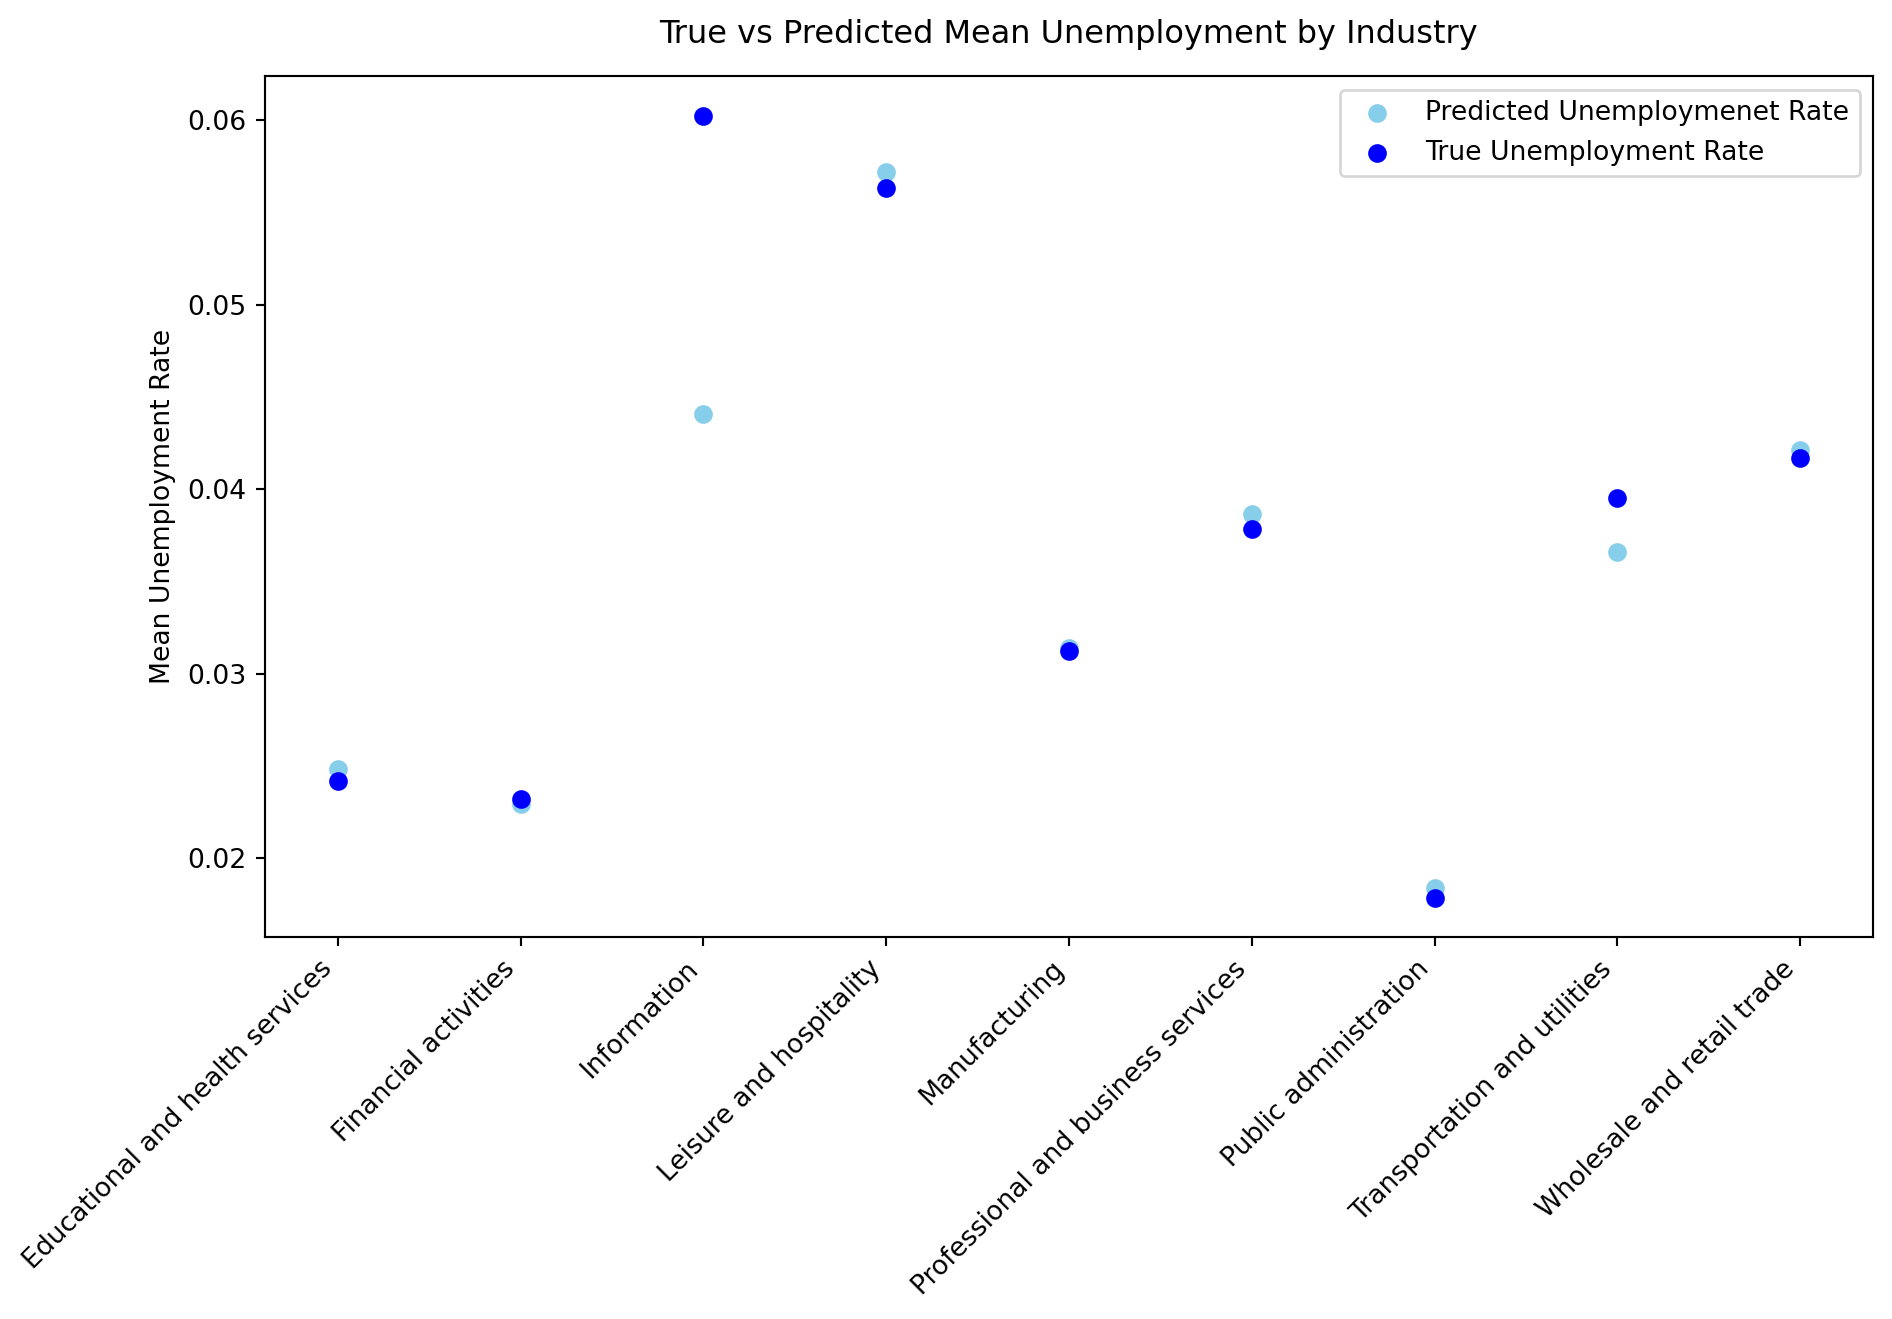

In [35]:
#| label: fig-scatter-industry-unemployment
#| fig-cap: Scatter Plot - Predictive Unemployment Rate vs. True Rate By Industries
#| fig-alt: Plot the unemployment rate means predicted by industry PGM model and the survey results

# Scatter plot
x = np.arange(len(ind_rate_df))
fig, ax = plt.subplots(figsize = (10, 7))
ax.scatter(
    x,
    ind_rate_df['unemployment_mean_pred'],
    color = 'skyblue',
    label = 'Predicted Unemploymenet Rate'
)

ax.scatter(
    x,
    ind_rate_df['unemployment_mean_true'],
    color='blue',
    label = 'True Unemployment Rate'
)
ax.set_xticks(x)
ax.set_xticklabels(ind_rate_df['industry_name'],rotation=45, ha="right")

ax.set_ylabel("Mean Unemployment Rate")
ax.set_title("True vs Predicted Mean Unemployment by Industry", y = 1.02)
ax.legend()

plt.tight_layout()
plt.show()

The scatter plot (@fig-scatter-industry-unemployment) compares true and predicted unemployment rates for each industry. Most industries show close alignment between the two measures, indicating good predictive accuracy. Alghouth Leisure and hospitality and Information show slightly higher gaps, suggesting the model under- or overestimates unemployment rates. Industries such as Leisure and hospitality and Information exhibit the highest unemployment rates, both in true and predicted values. In contrast, Public administration and Educational and health services have the lowest unemployment rates, which is same as what is observed from the historical data. 

Finally, we are analyzing the difference of the unemployment between recent gradatues and non recent graduates, and its interactive effect with education_attainment.

### Recent_graduate-education model - Survey data of age, education attainment and employment status
Create df_age_education using 2025 year to date survey data

```python
survey_file_names = ['apr_2025.csv', 'may_2025.csv', 'jun_2025.csv', 'jul_2025.csv']
cols = ['peeduca', 'prtage', 'pemlr'] # keep columns age, education_attainment and employment_status
survey_df_age_education = []
for s in survey_file_names:
    survey_file = pd.read_csv(os.path.join('../data/survey_data/', s))
    survey_data_maytojul = survey_file[cols]
    survey_data_maytojul.columns=['education_attainment', 'age', 'employment_status']
    survey_data_maytojul['month_year'] = s
    survey_df_age_education.append(survey_data_maytojul)

# Combine all into a single DataFrame
survey_df_age_education = pd.concat(survey_df_age_education, ignore_index=True)

# Exclude observations with age less than 22
survey_df_age_education = survey_df_age_education[survey_df_age_education['age']>=22]

# Decode the columns
survey_df_age_education['age_group'] = np.where(
    (survey_df_age_education['age']>=22) & (survey_df_age_education['age']<=25), '22-25', '26+')

survey_df_age_education['education_attainment_description'] = survey_df_age_education['education_attainment'].map(education_attainment_mapping)

# Only keep observations with bachelor's or master's degrees
survey_df_age_education = survey_df_age_education[(survey_df_age_education['education_attainment_description']=='bachelors_degree') | (survey_df_age_education['education_attainment_description']=='masters_degree')]

survey_df_age_education['employment_status_description'] = survey_df_age_education['employment_status'].map(employment_status_mapping)

# Exclude observations not in labor force
survey_df_age_education = survey_df_age_education[survey_df_age_education['employment_status_description'] !='not in labor force']

survey_df_age_education['unemployment_status'] = survey_df_age_education['employment_status_description'].map({'employed': 0, 'unemployed': 1})

survey_df_age_education['is_bachelors'] = (survey_df_age_education['education_attainment_description']=='bachelors_degree').astype(int)

survey_df_age_education['is_masters'] = (survey_df_age_education['education_attainment_description']=='masters_degree').astype(int)

survey_df_age_education['is_recent_graduate'] = (survey_df_age_education['age_group']=='22-25').astype(int)

survey_df_age_education['isnot_recent_graduate'] = (survey_df_age_education['age_group']=='26+').astype(int)

```

In [36]:
#| label: tbl-age-education
#| tbl-cap: Survey data of May through Jul 2025 that contains education attainment, age and unemployment status

survey_file_names = ['apr_2025.csv', 'may_2025.csv', 'jun_2025.csv', 'jul_2025.csv']
cols = ['peeduca', 'prtage', 'pemlr'] # keep columns age, education_attainment and employment_status
survey_df_age_education = []
for s in survey_file_names:
    survey_file = pd.read_csv(os.path.join('../data/survey_data/', s))
    survey_data_maytojul = survey_file[cols]
    survey_data_maytojul.columns=['education_attainment', 'age', 'employment_status']
    survey_data_maytojul['month_year'] = s
    survey_df_age_education.append(survey_data_maytojul)

# Combine all into a single DataFrame
survey_df_age_education = pd.concat(survey_df_age_education, ignore_index=True)

# Exclude observations with age less than 22
survey_df_age_education = survey_df_age_education[survey_df_age_education['age']>=22]

# Decode the columns
survey_df_age_education['age_group'] = np.where(
    (survey_df_age_education['age']>=22) & (survey_df_age_education['age']<=25), '22-25', '26+')

survey_df_age_education['education_attainment_description'] = survey_df_age_education['education_attainment'].map(education_attainment_mapping)

# Only keep observations with bachelor's or master's degrees
survey_df_age_education = survey_df_age_education[(survey_df_age_education['education_attainment_description']=='bachelors_degree') | (survey_df_age_education['education_attainment_description']=='masters_degree')]

survey_df_age_education['employment_status_description'] = survey_df_age_education['employment_status'].map(employment_status_mapping)

# Exclude observations not in labor force
survey_df_age_education = survey_df_age_education[survey_df_age_education['employment_status_description'] !='not in labor force']

survey_df_age_education['unemployment_status'] = survey_df_age_education['employment_status_description'].map({'employed': 0, 'unemployed': 1})

survey_df_age_education['is_bachelors'] = (survey_df_age_education['education_attainment_description']=='bachelors_degree').astype(int)

survey_df_age_education['is_masters'] = (survey_df_age_education['education_attainment_description']=='masters_degree').astype(int)

survey_df_age_education['is_recent_graduate'] = (survey_df_age_education['age_group']=='22-25').astype(int)

survey_df_age_education['isnot_recent_graduate'] = (survey_df_age_education['age_group']=='26+').astype(int)

display(survey_df_age_education.head(10).style.hide(axis='index'))

education_attainment,age,employment_status,month_year,age_group,education_attainment_description,employment_status_description,unemployment_status,is_bachelors,is_masters,is_recent_graduate,isnot_recent_graduate
43,50,1,apr_2025.csv,26+,bachelors_degree,employed,0,1,0,0,1
43,44,1,apr_2025.csv,26+,bachelors_degree,employed,0,1,0,0,1
44,44,1,apr_2025.csv,26+,masters_degree,employed,0,0,1,0,1
43,80,1,apr_2025.csv,26+,bachelors_degree,employed,0,1,0,0,1
43,34,1,apr_2025.csv,26+,bachelors_degree,employed,0,1,0,0,1
43,34,1,apr_2025.csv,26+,bachelors_degree,employed,0,1,0,0,1
44,40,1,apr_2025.csv,26+,masters_degree,employed,0,0,1,0,1
44,34,1,apr_2025.csv,26+,masters_degree,employed,0,0,1,0,1
43,57,1,apr_2025.csv,26+,bachelors_degree,employed,0,1,0,0,1
43,23,1,apr_2025.csv,22-25,bachelors_degree,employed,0,1,0,1,0


### Recent_graduate-education model - train-test split
```python
# train-test split
train_df_age_education, test_df_age_education = train_test_split(survey_df_age_education, test_size=0.2, random_state = 5650)

X_train_ae = train_df_age_education[['is_bachelors', 'is_masters', 'is_lower_than_bachelors',	'is_recent_graduate']]

y_train_ae = train_df_age_education['unemployment_status']

X_test_ae = test_df_age_education[['is_bachelors', 'is_masters', 'is_lower_than_bachelors',	'is_recent_graduate']]

y_test_ae = test_df_age_education['unemployment_status']
```

In [37]:
# train-test split
train_df_age_education, test_df_age_education = train_test_split(survey_df_age_education, test_size=0.2, random_state = 5650)

X_train_ae = train_df_age_education[['is_bachelors', 'is_masters', 'is_recent_graduate']]

y_train_ae = train_df_age_education['unemployment_status']

X_test_ae = test_df_age_education[['is_bachelors', 'is_masters', 	'is_recent_graduate']]

y_test_ae = test_df_age_education['unemployment_status']

### Recent_graduate-education model - define the multivariate model

```python
coords = {'response_id': X_train_ae.index.values}
with pm.Model(coords=coords) as age_education_model:
    # obsereved data
    recent_graduate_obs = pm.Data("recent_graduate_obs", X_train_ae['is_recent_graduate'], dims="response_id")

    bachelors_obs = pm.Data('is_bachelors_obs', X_train_ae['is_bachelors'], dims='response_id')

    masters_obs = pm.Data('is_masters_obs', X_train_ae['is_masters'], dims='response_id')

    # Prior of population mean log odds
    mu_population_log_odds = pm.Normal('mu_population_log_odds', mu=population_mean_log_odds, sigma=0.5)

    # Beta of degrees and recent_graduate variables
    beta_master = pm.Normal("beta_master", 0, 1)
    beta_bachelor = pm.Normal("beta_bachelor", 0, 1) 
    beta_recent_graduate = pm.Normal("beta_recent_graduate", 0, 1)
    beta_recent_graduate_bachelor = pm.Normal("beta_recent_graduate_bachelor", 0, 1)
    beta_recent_graduate_master = pm.Normal("beta_recent_graduate_master", 0, 1)

    # p_unemployment determined by variables
    p_unemployment = pm.Deterministic("p_sayhire", pm.math.invlogit(mu_population_log_odds + beta_bachelor * bachelors_obs + beta_master * masters_obs + beta_recent_graduate * recent_graduate_obs + beta_recent_graduate_bachelor * recent_graduate_obs * bachelors_obs + beta_recent_graduate_master * masters_obs * recent_graduate_obs ), dims = 'response_id')
    # unemployment
    unemployment_obs = pm.Data("unemployment_obs", y_train_ae, dims="response_id")
    unemployment = pm.Bernoulli("unemployment", p = p_unemployment, observed=unemployment_obs, dims="response_id")
```

In [38]:
coords = {'response_id': X_train_ae.index.values}
with pm.Model(coords=coords) as age_education_model:
    # obsereved data
    recent_graduate_obs = pm.Data("recent_graduate_obs", X_train_ae['is_recent_graduate'], dims="response_id")

    bachelors_obs = pm.Data('is_bachelors_obs', X_train_ae['is_bachelors'], dims='response_id')

    masters_obs = pm.Data('is_masters_obs', X_train_ae['is_masters'], dims='response_id')

    # Prior of population mean log odds
    mu_population_log_odds = pm.Normal('mu_population_log_odds', mu=population_mean_log_odds, sigma=0.5)

    # Beta of degrees and recent_graduate variables
    beta_master = pm.Normal("beta_master", 0, 1)
    beta_bachelor = pm.Normal("beta_bachelor", 0, 1) 
    beta_recent_graduate = pm.Normal("beta_recent_graduate", 0, 1)
    beta_recent_graduate_bachelor = pm.Normal("beta_recent_graduate_bachelor", 0, 1)
    beta_recent_graduate_master = pm.Normal("beta_recent_graduate_master", 0, 1)

    # p_unemployment determined by variables
    p_unemployment = pm.Deterministic("p_unemployment", pm.math.invlogit(mu_population_log_odds + beta_bachelor * bachelors_obs + beta_master * masters_obs + beta_recent_graduate * recent_graduate_obs + beta_recent_graduate_bachelor * recent_graduate_obs * bachelors_obs + beta_recent_graduate_master * masters_obs * recent_graduate_obs ), dims = 'response_id')
    # unemployment
    unemployment_obs = pm.Data("unemployment_obs", y_train_ae, dims="response_id")
    unemployment = pm.Bernoulli("unemployment", p = p_unemployment, observed=unemployment_obs, dims="response_id")

### Recent_graduate-education model - Graph PGM
```python
pm.model_to_graphviz(age_education_model)
```

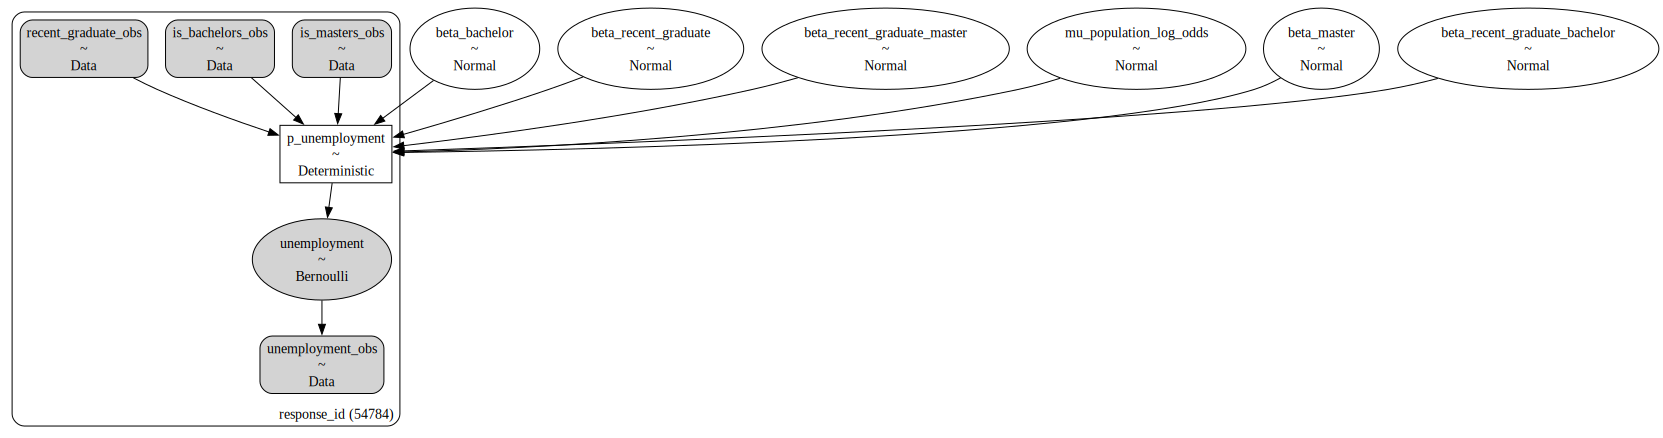

In [39]:
pm.model_to_graphviz(age_education_model)

### Recent_graduate-education model - Estimate model parameters
```python
print("Starting Recent_graduate-Education Model Sampling...")
with age_education_model:
    ae_idata = pm.sample(random_seed=5650)
```

In [40]:
print("Starting Recent_graduate-Education Model Sampling...")
with age_education_model:
    ae_idata = pm.sample(random_seed=5650)

Initializing NUTS using jitter+adapt_diag...


Starting Recent_graduate-Education Model Sampling...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mu_population_log_odds, beta_master, beta_bachelor, beta_recent_graduate, beta_recent_graduate_bachelor, beta_recent_graduate_master]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 197 seconds.


```python
# Analyze Results and Visualize
print("\n--- Model Summary (Recent_graduate-Education Model) ---")
display(pd.DataFrame(az.summary(ae_idata)))
```

In [41]:
#| label: tbl-recent-graduate-education-model-params
#| tbl-cap: Estimated Parameters of Recent Graudate - Education Model

# Posterior summary
print("\n--- Model Summary (Recent Graduate - Education Model) ---")
display(pd.DataFrame(az.summary(ae_idata)))


--- Model Summary (Recent Graduate - Education Model) ---


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_population_log_odds,-3.284,0.416,-4.110,-2.553,0.013,0.008,962.0,1337.0,1.01
beta_master,-0.371,0.418,-1.136,0.428,0.014,0.008,967.0,1322.0,1.01
beta_bachelor,-0.331,0.417,-1.056,0.491,0.013,0.008,981.0,1331.0,1.01
beta_recent_graduate,0.469,0.592,-0.673,1.599,0.018,0.013,1110.0,1245.0,1.01
beta_recent_graduate_bachelor,0.162,0.596,-0.967,1.302,0.018,0.013,1124.0,1213.0,1.01
...,...,...,...,...,...,...,...,...,...
p_unemployment[108302],0.026,0.001,0.025,0.028,0.000,0.000,4286.0,3299.0,1.00
p_unemployment[173313],0.025,0.001,0.023,0.027,0.000,0.000,4448.0,3581.0,1.00
p_unemployment[184357],0.025,0.001,0.023,0.027,0.000,0.000,4448.0,3581.0,1.00
p_unemployment[164868],0.025,0.001,0.023,0.027,0.000,0.000,4448.0,3581.0,1.00


@tbl-recent-graduate-education-model-params shows posterior distribution on train data including mu_population_log_odds, beta, p_unemployment

### Recent Graduate - Education model - Extract Posterior Predictive Distribution on Test data

```python
# Update to test data
test_coords = {
    'response_id': X_test_ae.index.values
}
with age_education_model:
    pm.set_data({"unemployment_obs": y_test_ae,
                 "is_bachelors_obs": X_test_ae['is_bachelors'],
                 "is_masters_obs": X_test_ae['is_masters'],
                 "recent_graduate_obs": X_test_ae['is_recent_graduate']},
                 coords=test_coords)

with age_education_model:
    ae_test_idata = pm.sample_posterior_predictive(ae_idata, random_seed=5650)
```

In [42]:
# Update to test data
test_coords = {
    'response_id': X_test_ae.index.values
}
with age_education_model:
    pm.set_data({"unemployment_obs": y_test_ae,
                 "is_bachelors_obs": X_test_ae['is_bachelors'],
                 "is_masters_obs": X_test_ae['is_masters'],
                 "recent_graduate_obs": X_test_ae['is_recent_graduate']},
                 coords=test_coords)

with age_education_model:
    ae_test_idata = pm.sample_posterior_predictive(ae_idata, random_seed=5650)

Sampling: [unemployment]


Output()

```python
# Extract means of unemployment values from the posterior predictive distribution given test data
ae_test_meanunemployment = ae_test_idata.posterior_predictive['unemployment'].mean(dim=['chain','draw'])
print(ae_test_meanunemployment.values)
```

In [43]:
# Extract means of unemployment values from the posterior predictive distribution given test data
ae_test_meanunemployment = ae_test_idata.posterior_predictive['unemployment'].mean(dim=['chain','draw'])
print(ae_test_meanunemployment.values)

[0.0235  0.02675 0.0275  ... 0.02775 0.02675 0.05375]


### Recent Graduate - Education model - Plot predictive vs. unemployment rate in the test data

```python
bachelors_obs = ae_test_idata.constant_data['is_bachelors_obs'].values
masters_obs = ae_test_idata.constant_data['is_masters_obs'].values  

education_list = [
    'Bachelors' if b == 1 else
    'Masters' if m == 1 else None
    for b, m in zip(bachelors_obs, masters_obs)
]

recent_graduate_obs = ae_test_idata.constant_data['recent_graduate_obs'].values

recent_graduate_list = [
    'Recent graduate' if r ==1 else
    'Not Recent graduate'  
    for r in recent_graduate_obs
]

ae_df = pd.DataFrame({
    'education_list': education_list, 
    'recent_graduate_list': recent_graduate_list, 
    'y_predict': ae_test_idata.posterior_predictive['unemployment'].mean(dim=['chain','draw']).values, 
    'y_true': ae_test_idata.observed_data['unemployment'].values
    })

ae_rate_df = ae_df.groupby(['education_list','recent_graduate_list'])[['y_predict','y_true']].mean().reset_index()
ae_rate_df_long = ae_rate_df.melt(id_vars=["education_list", "recent_graduate_list"], var_name="y_label", value_name="unemployment_rate_mean")

# Bar plot
fig, axes = plt.subplots(1, 2, figsize = (10, 6), sharey=True)
## Bachelor's plot
sns.barplot(
     x="recent_graduate_list", y='unemployment_rate_mean', hue='y_label', 
     data=ae_rate_df_long[ae_rate_df_long['education_list']=='Bachelors'],
     alpha=0.9,
     ax=axes[0],
     palette={"y_predict": "skyblue", "y_true": "blue"}
)
axes[0].set_title("Bachelors")
axes[0].set_ylabel("Unemployment Rate Mean")
axes[0].set_xlabel("Recent Graduate Status")
axes[0].legend(title="Data Type")
## Master's plot
sns.barplot(
     x="recent_graduate_list", y='unemployment_rate_mean', hue='y_label', 
     data=ae_rate_df_long[ae_rate_df_long['education_list']=='Masters'],
     alpha=0.9,
     ax=axes[1],
     palette={"y_predict": "lightcoral", "y_true": "red"}
)
axes[1].set_title("Masters")
axes[1].set_xlabel("Recent Graduate Status")
axes[1].legend(title='Data Type') 

fig.suptitle("Rates of 'Predictive Unemployment' mean vs. 'True Unemployment' mean", fontsize=16, y = 1.02)

# plt.tight_layout()
# plt.show()
```

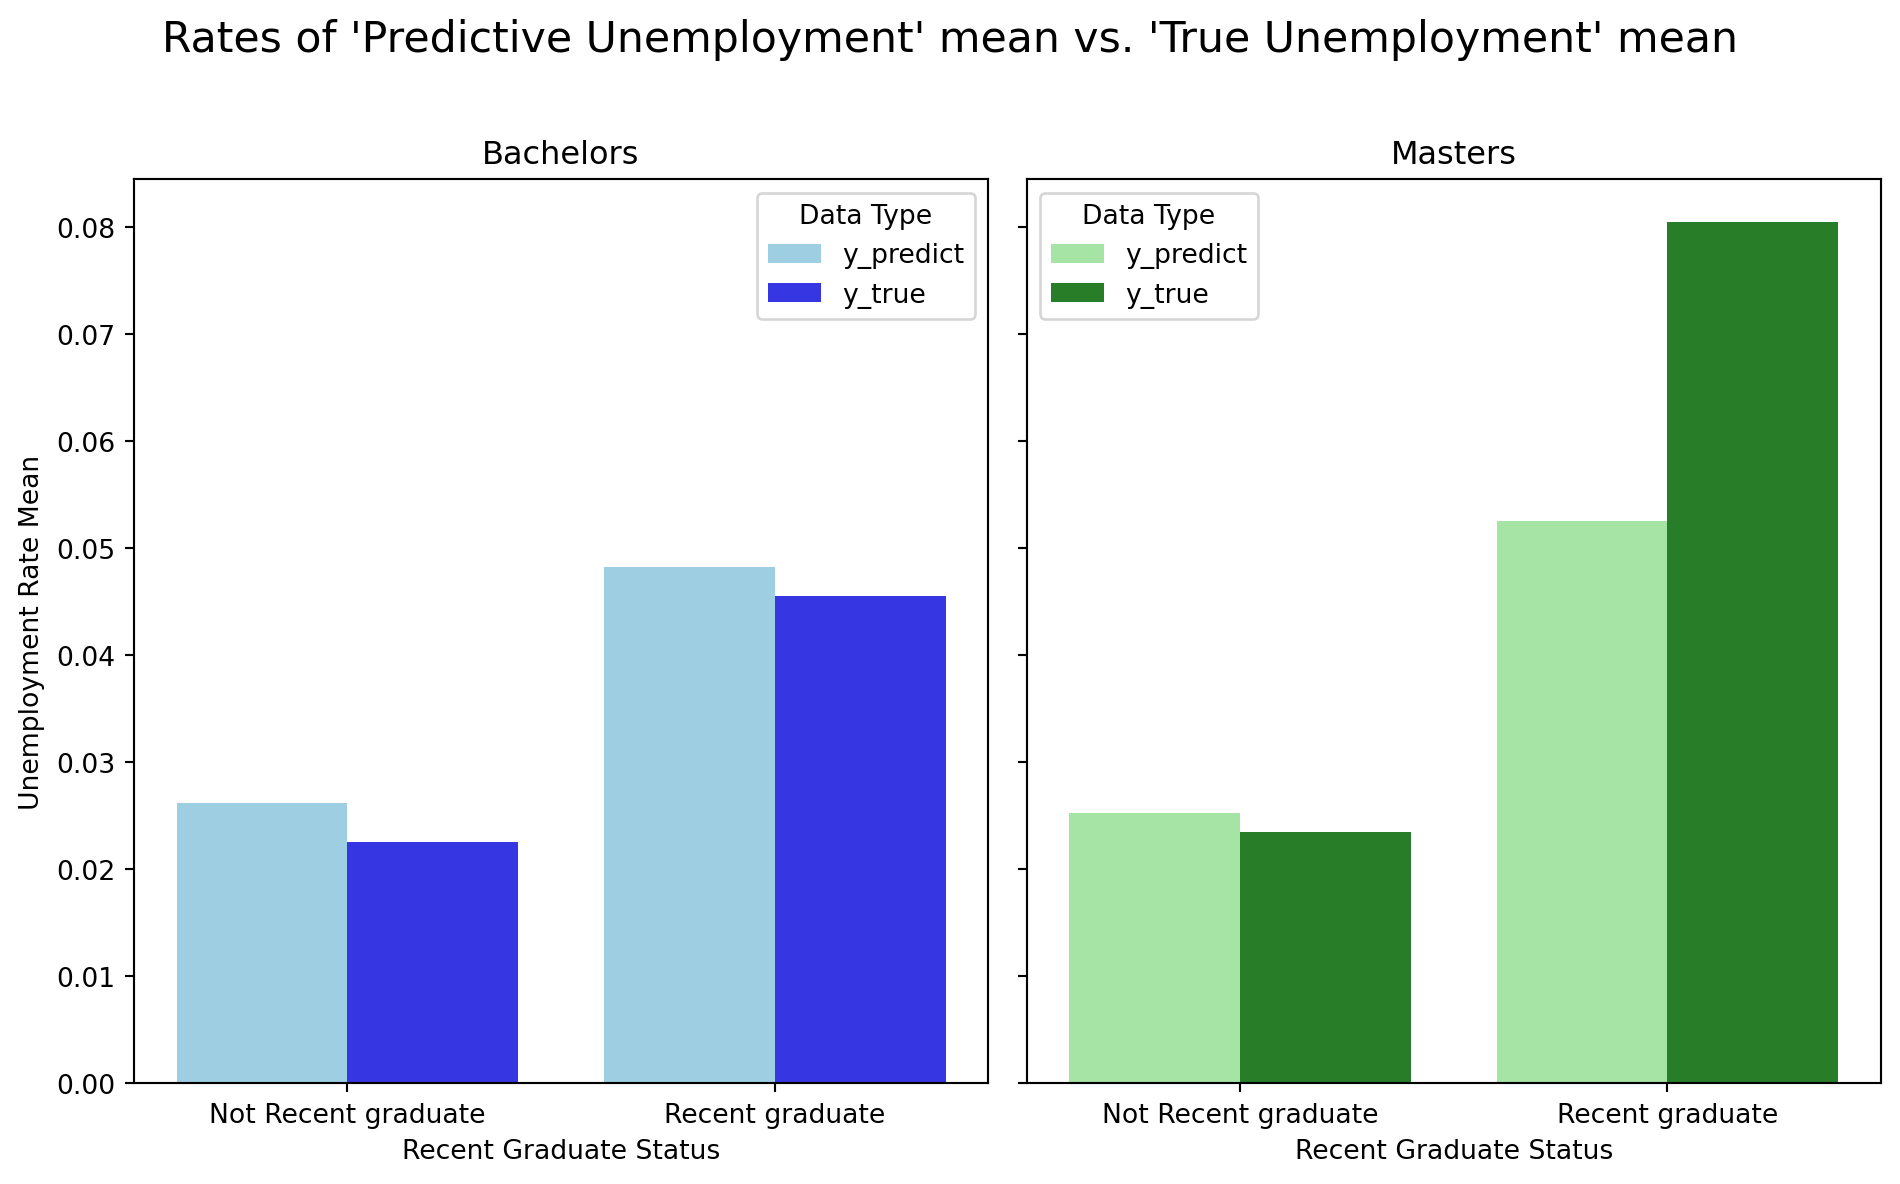

In [44]:
#| label: fig-bar-recent-graduate-education-model
#| fig-cap: Bar Plot - Predictive Unemployment Mean Rate vs. True Mean Rate By Recent Graduate and Education Level
#| fig-alt: Plot the unemployment rate means predicted by race PGM model and the survey results

bachelors_obs = ae_test_idata.constant_data['is_bachelors_obs'].values
masters_obs = ae_test_idata.constant_data['is_masters_obs'].values  

education_list = [
    'Bachelors' if b == 1 else
    'Masters' if m == 1 else None
    for b, m in zip(bachelors_obs, masters_obs)
]

recent_graduate_obs = ae_test_idata.constant_data['recent_graduate_obs'].values

recent_graduate_list = [
    'Recent graduate' if r ==1 else
    'Not Recent graduate'  
    for r in recent_graduate_obs
]

ae_df = pd.DataFrame({
    'education_list': education_list, 
    'recent_graduate_list': recent_graduate_list, 
    'y_predict': ae_test_idata.posterior_predictive['unemployment'].mean(dim=['chain','draw']).values, 
    'y_true': ae_test_idata.observed_data['unemployment'].values
    })

ae_rate_df = ae_df.groupby(['education_list','recent_graduate_list'])[['y_predict','y_true']].mean().reset_index()
ae_rate_df_long = ae_rate_df.melt(id_vars=["education_list", "recent_graduate_list"], var_name="y_label", value_name="unemployment_rate_mean")

# Bar plot
fig, axes = plt.subplots(1, 2, figsize = (10, 6), sharey=True)
## Bachelor's plot
sns.barplot(
     x="recent_graduate_list", y='unemployment_rate_mean', hue='y_label', 
     data=ae_rate_df_long[ae_rate_df_long['education_list']=='Bachelors'],
     alpha=0.9,
     ax=axes[0],
     palette={"y_predict": "skyblue", "y_true": "blue"}
)
axes[0].set_title("Bachelors")
axes[0].set_ylabel("Unemployment Rate Mean")
axes[0].set_xlabel("Recent Graduate Status")
axes[0].legend(title="Data Type")
## Master's plot
sns.barplot(
     x="recent_graduate_list", y='unemployment_rate_mean', hue='y_label', 
     data=ae_rate_df_long[ae_rate_df_long['education_list']=='Masters'],
     alpha=0.9,
     ax=axes[1],
     palette={"y_predict": "lightgreen", "y_true": "green"}
)
axes[1].set_title("Masters")
axes[1].set_xlabel("Recent Graduate Status")
axes[1].legend(title='Data Type') 

fig.suptitle("Rates of 'Predictive Unemployment' mean vs. 'True Unemployment' mean", fontsize=16, y = 1.02)

plt.tight_layout()
plt.show()

The bar plot above (@fig-bar-recent-graduate-model) shows that the model predicts unemployment rates for individuals in the labor force with a Bachelor's degree as their highest educational attainment quite accurately, with recent graduates (aged 22–25) exhibiting notably higher unemployment than non-recent graduates. For individuals with a Master's degree, the model performs well for non-recent graduates but shows a larger gap in predictions for recent graduates, likely due to limited training data. Nevertheless, the model captures the real-world trend that recent graduates face greater challenges in the job market compared to older cohorts.

## References {.unnumbered}

::: {#refs}
:::